## Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import csv
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from scipy.stats import pearsonr
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV

In [2]:
import sys
import os
sys.path.append(os.path.dirname(os.path.dirname(os.getcwd())))
if not os.path.exists("./data"):
    os.makedirs("./data")
if not os.path.exists("./data/model"):
    os.makedirs("./data/model")
if not os.path.exists("./data/preprocessing"):
    os.makedirs("./data/preprocessing")
if not os.path.exists("./data/dataset"):
    os.makedirs("./data/dataset")

## Reusable Function

In [21]:
def boxplot_los_groupby(variable, los_range=(-1, 30), size=(8,4)):
    results = df[[variable, 'los']].groupby(variable).median().reset_index()

    categories = results[variable].values.tolist()

    hist_data = []
    for cat in categories:
        hist_data.append(df['los'].loc[df[variable]==cat].values)

    fig, ax = plt.subplots(figsize=size)
    ax.boxplot(hist_data, 0, '', vert=False)
    ax.set_xlim(los_range)
    ax.set_yticklabels(categories)
    ax.set_xlabel('Length of Stay (days)')
    ax.tick_params(left=False, right=False) 
    ax.set_title('Comparison of {} categories'.format(variable))
    plt.tight_layout()
    plt.show()

## Extract Patients Data from ICUstays

In [3]:
icu = pd.read_csv('./mimiciv/2.0/icu/icustays.csv.gz',compression='gzip')
adm = pd.read_csv('./mimiciv/2.0/hosp/admissions.csv.gz',compression='gzip')
patients = pd.read_csv('./mimiciv/2.0/hosp/patients.csv.gz',compression='gzip')

In [4]:
icu.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73181 entries, 0 to 73180
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   subject_id      73181 non-null  int64  
 1   hadm_id         73181 non-null  int64  
 2   stay_id         73181 non-null  int64  
 3   first_careunit  73181 non-null  object 
 4   last_careunit   73181 non-null  object 
 5   intime          73181 non-null  object 
 6   outtime         73181 non-null  object 
 7   los             73181 non-null  float64
dtypes: float64(1), int64(3), object(4)
memory usage: 4.5+ MB


In [5]:
adm.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 431231 entries, 0 to 431230
Data columns (total 16 columns):
 #   Column                Non-Null Count   Dtype 
---  ------                --------------   ----- 
 0   subject_id            431231 non-null  int64 
 1   hadm_id               431231 non-null  int64 
 2   admittime             431231 non-null  object
 3   dischtime             431231 non-null  object
 4   deathtime             8598 non-null    object
 5   admission_type        431231 non-null  object
 6   admit_provider_id     431227 non-null  object
 7   admission_location    431231 non-null  object
 8   discharge_location    312076 non-null  object
 9   insurance             431231 non-null  object
 10  language              431231 non-null  object
 11  marital_status        421998 non-null  object
 12  race                  431231 non-null  object
 13  edregtime             299282 non-null  object
 14  edouttime             299282 non-null  object
 15  hospital_expire_f

In [6]:
#drop unneccessary columns
drop_adm = adm.drop(columns=['admittime','dischtime','deathtime','admission_type',
                             'admit_provider_id','admission_location','discharge_location',
                             'insurance','language','marital_status','race','edregtime','edouttime'])

In [7]:
drop_adm.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 431231 entries, 0 to 431230
Data columns (total 3 columns):
 #   Column                Non-Null Count   Dtype
---  ------                --------------   -----
 0   subject_id            431231 non-null  int64
 1   hadm_id               431231 non-null  int64
 2   hospital_expire_flag  431231 non-null  int64
dtypes: int64(3)
memory usage: 9.9 MB


In [8]:
#merge icu with filtered admission
df = icu.merge(drop_adm[['hadm_id','hospital_expire_flag']], on='hadm_id', how='inner')

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 73181 entries, 0 to 73180
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   subject_id            73181 non-null  int64  
 1   hadm_id               73181 non-null  int64  
 2   stay_id               73181 non-null  int64  
 3   first_careunit        73181 non-null  object 
 4   last_careunit         73181 non-null  object 
 5   intime                73181 non-null  object 
 6   outtime               73181 non-null  object 
 7   los                   73181 non-null  float64
 8   hospital_expire_flag  73181 non-null  int64  
dtypes: float64(1), int64(4), object(4)
memory usage: 5.6+ MB


In [10]:
df.head()

,subject_id,hadm_id,stay_id,first_careunit,last_careunit,intime,outtime,los,hospital_expire_flag
0,10000032,29079034,39553978,Medical Intensive Care Unit (MICU),Medical Intensive Care Unit (MICU),2180-07-23 14:00:00,2180-07-23 23:50:47,0.410266,0
1,10000980,26913865,39765666,Medical Intensive Care Unit (MICU),Medical Intensive Care Unit (MICU),2189-06-27 08:42:00,2189-06-27 20:38:27,0.497535,0
2,10001217,24597018,37067082,Surgical Intensive Care Unit (SICU),Surgical Intensive Care Unit (SICU),2157-11-20 19:18:02,2157-11-21 22:08:00,1.118032,0
3,10001217,27703517,34592300,Surgical Intensive Care Unit (SICU),Surgical Intensive Care Unit (SICU),2157-12-19 15:42:24,2157-12-20 14:27:41,0.948113,0
4,10001725,25563031,31205490,Medical/Surgical Intensive Care Unit (MICU/SICU),Medical/Surgical Intensive Care Unit (MICU/SICU),2110-04-11 15:52:22,2110-04-12 23:59:56,1.338588,0


In [11]:
#Filter the 'icu' DataFrame to include only patients with at least 5 hours of data (los > 5/24 days)
filtered_icu = icu[icu['los'] > 5/24]

In [12]:
#Merge the 'patients' and filtered 'icu' DataFrames based on the 'subject_id' column
filtered_pats = patients.merge(filtered_icu[['subject_id', 
                                             'intime', 'los']],on='subject_id', how='inner')

In [13]:
filtered_pats.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 72390 entries, 0 to 72389
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   subject_id         72390 non-null  int64  
 1   gender             72390 non-null  object 
 2   anchor_age         72390 non-null  int64  
 3   anchor_year        72390 non-null  int64  
 4   anchor_year_group  72390 non-null  object 
 5   dod                27908 non-null  object 
 6   intime             72390 non-null  object 
 7   los                72390 non-null  float64
dtypes: float64(1), int64(3), object(4)
memory usage: 5.0+ MB


In [14]:
# Filter out anyone whose age is less than or equal to 17 at the time of ICU admission
filtered_pats = filtered_pats[filtered_pats['anchor_age'] > 17]

In [15]:
filtered_pats.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 72390 entries, 0 to 72389
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   subject_id         72390 non-null  int64  
 1   gender             72390 non-null  object 
 2   anchor_age         72390 non-null  int64  
 3   anchor_year        72390 non-null  int64  
 4   anchor_year_group  72390 non-null  object 
 5   dod                27908 non-null  object 
 6   intime             72390 non-null  object 
 7   los                72390 non-null  float64
dtypes: float64(1), int64(3), object(4)
memory usage: 5.0+ MB


In [16]:
df = df.merge(filtered_pats[['subject_id','gender','anchor_age']], on='subject_id', how='inner')

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 170453 entries, 0 to 170452
Data columns (total 11 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   subject_id            170453 non-null  int64  
 1   hadm_id               170453 non-null  int64  
 2   stay_id               170453 non-null  int64  
 3   first_careunit        170453 non-null  object 
 4   last_careunit         170453 non-null  object 
 5   intime                170453 non-null  object 
 6   outtime               170453 non-null  object 
 7   los                   170453 non-null  float64
 8   hospital_expire_flag  170453 non-null  int64  
 9   gender                170453 non-null  object 
 10  anchor_age            170453 non-null  int64  
dtypes: float64(1), int64(5), object(5)
memory usage: 15.6+ MB


In [17]:
#save icu cohort csv file
df.to_csv('./data/preprocessing/icu_cohort.csv.gz', index=False)

(1.0, 120.0)

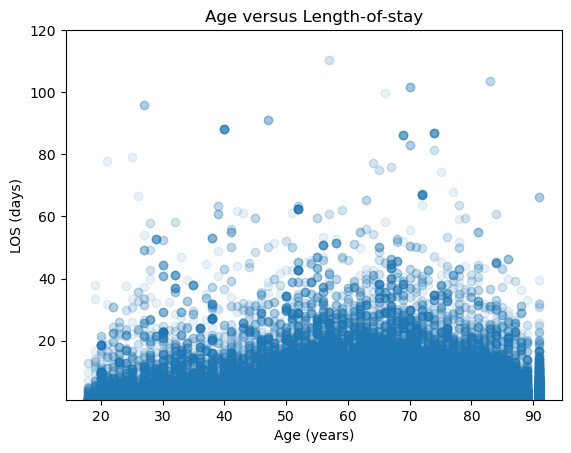

In [19]:
#plot for patients age vs los
plt.scatter(df['anchor_age'], df['los'], alpha=0.1)
plt.ylabel('LOS (days)')
plt.xlabel('Age (years)')
plt.title('Age versus Length-of-stay')
plt.ylim(1, 120)

__*Scatter Plot Observation*__
- The average LOS for patients in their 60s is around 10 days, but there are some patients in this age group who have an LOS of less than 5 days or more than 20 days.
- The median LOS is around 10 days. 
- There are a few outliers (Higher than average LOS) in the data. 

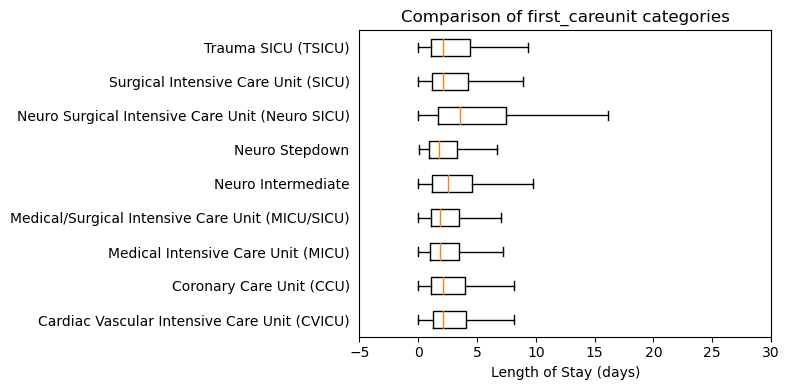

In [22]:
boxplot_los_groupby('first_careunit',los_range=(-5,30))

### Labs Stay
extracting the itemids for all the labevents that occur within the time bounds for our cohort

In [3]:
icu_cohort = pd.read_csv('./data/preprocessing/icu_cohort.csv.gz',compression='gzip')

In [4]:
labitems = pd.read_csv('./mimiciv/2.0/hosp/d_labitems.csv.gz',compression='gzip')

In [27]:
labitems.head()

,itemid,label,fluid,category
0,50801,Alveolar-arterial Gradient,Blood,Blood Gas
1,50802,Base Excess,Blood,Blood Gas
2,50803,"Calculated Bicarbonate, Whole Blood",Blood,Blood Gas
3,50804,Calculated Total CO2,Blood,Blood Gas
4,50805,Carboxyhemoglobin,Blood,Blood Gas


In [28]:
category_counts = labitems.groupby('category')['itemid'].count()

print(category_counts)

category
Blood Gas      64
Chemistry     777
Hematology    781
Name: itemid, dtype: int64


In [29]:
file_path = './mimiciv/2.0/hosp/labevents.csv.gz'

chunk_size = 100000 
chunks = []

for chunk in pd.read_csv(file_path, chunksize=chunk_size):
    merge_chunk = chunk.merge(icu_cohort[['stay_id', 'hadm_id', 'intime', 'los']], on='hadm_id', how='inner')
    
    # Filter only numerical data
    merge_chunk = merge_chunk[merge_chunk['valuenum'].notnull()]
    
    # Convert the 'charttime' and 'intime' columns to pandas DateTime objects
    merge_chunk['charttime'] = pd.to_datetime(merge_chunk['charttime'])
    merge_chunk['intime'] = pd.to_datetime(merge_chunk['intime'])
    
    # Calculate the time difference between 'charttime' and 'intime' in days
    # we want to extract measurements between admission and the end of the patients' stay
    merge_chunk['time_diff_days'] = (merge_chunk['charttime'] - merge_chunk['intime']).dt.total_seconds() / (60 * 60 * 24)
    
    # Filter the rows in 'merge_chunk' 
    merge_chunk = merge_chunk[(merge_chunk['time_diff_days'] >= -1) & (merge_chunk['time_diff_days'] <= merge_chunk['los'])]
    
    chunks.append(merge_chunk)

labsstay = pd.concat(chunks, ignore_index=True)

C:\Users\User\AppData\Local\Temp\ipykernel_7652\1204666657.py:6: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in pd.read_csv(file_path, chunksize=chunk_size):
C:\Users\User\AppData\Local\Temp\ipykernel_7652\1204666657.py:6: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in pd.read_csv(file_path, chunksize=chunk_size):
C:\Users\User\AppData\Local\Temp\ipykernel_7652\1204666657.py:6: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in pd.read_csv(file_path, chunksize=chunk_size):
C:\Users\User\AppData\Local\Temp\ipykernel_7652\1204666657.py:6: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in pd.read_csv(file_path, chunksize=chunk_size):
C:\Users\User\AppData\Local\Temp\ipykernel_7652\1204666657.py:6: DtypeWarning: Columns (5) have 

C:\Users\User\AppData\Local\Temp\ipykernel_7652\1204666657.py:6: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in pd.read_csv(file_path, chunksize=chunk_size):
C:\Users\User\AppData\Local\Temp\ipykernel_7652\1204666657.py:6: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in pd.read_csv(file_path, chunksize=chunk_size):
C:\Users\User\AppData\Local\Temp\ipykernel_7652\1204666657.py:6: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in pd.read_csv(file_path, chunksize=chunk_size):
C:\Users\User\AppData\Local\Temp\ipykernel_7652\1204666657.py:6: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in pd.read_csv(file_path, chunksize=chunk_size):
C:\Users\User\AppData\Local\Temp\ipykernel_7652\1204666657.py:6: DtypeWarning: Columns (5) have 

In [30]:
labsstay.shape

(38372040, 20)

## Common Labs 

### Average Observation Per Stay
getting the average number of times each itemid appears in an icustay

In [31]:
labsstay_counts = labsstay['stay_id'].value_counts().reset_index()
labsstay_counts.columns = ['stay_id', 'labsstay_count']
labsstay_counts

,stay_id,labsstay_count
0,36479755,63765
1,36671290,51252
2,31469106,48580
3,38199253,46222
4,34814635,46143
...,...,...
72093,36400520,1
72094,38046396,1
72095,32169536,1
72096,38886407,1


In [32]:
labsstay_counts.shape

(72098, 2)

In [33]:
ICU_counts = icu_cohort['stay_id'].value_counts().reset_index()
ICU_counts.columns = ['stay_id', 'ICU_count']
ICU_counts

,stay_id,ICU_count
0,31073147,37
1,34456715,37
2,32346798,37
3,35383104,37
4,34115393,37
...,...,...
72991,39824196,1
72992,33302469,1
72993,32622345,1
72994,33199830,1


In [34]:
ICU_counts.shape

(72996, 2)

In [35]:
#keep stayid where labsstay count > icu count
merged_counts = ICU_counts.merge(labsstay_counts, on='stay_id', how='outer').fillna(0)
filtered_stayid = merged_counts[(merged_counts['labsstay_count']) > merged_counts['ICU_count']]
filtered_stayid

,stay_id,ICU_count,labsstay_count
0,31073147,37,2701.0
1,34456715,37,370.0
2,32346798,37,111.0
3,35383104,37,2183.0
4,34115393,37,3663.0
...,...,...,...
72991,39824196,1,487.0
72992,33302469,1,621.0
72993,32622345,1,55.0
72994,33199830,1,24.0


In [36]:
filtered_stayid.shape

(72042, 3)

In [37]:
#Filter labsstays to only have these stay_ids
filtered_stayid_list = filtered_stayid['stay_id'].tolist()

In [38]:
chunk_size = 100000
num_chunks = len(labsstay) // chunk_size + 1

chunks = []

# Process the DataFrame in chunks
for i in range(num_chunks):
    start_idx = i * chunk_size
    end_idx = (i + 1) * chunk_size
    
    # Select the current chunk based on start and end indices
    chunk = labsstay.iloc[start_idx:end_idx]
    
    # Filter the chunk using 'filtered_stayid_list'
    filtered_chunk = chunk[chunk['stay_id'].isin(filtered_stayid_list)]
    
    # Append the processed chunk to the list
    chunks.append(filtered_chunk)

# After processing all chunks, concatenate them into a final DataFrame
filtered_labsstay = pd.concat(chunks, ignore_index=True)

In [39]:
filtered_labsstay.shape

(38371885, 20)

In [40]:
# Group by 'itemid' and 'stay_id' and calculate the observation count for each stay_id on itemid
obs_per_stay = filtered_labsstay.groupby(['itemid', 'stay_id']).size().reset_index(name='count')
obs_per_stay.head()

,itemid,stay_id,count
0,50801,30004627,1
1,50801,30005362,1
2,50801,30007565,2
3,50801,30010930,1
4,50801,30011071,7


In [41]:
min_count = obs_per_stay['count'].min()
max_count = obs_per_stay['count'].max()
avg_count = obs_per_stay['count'].mean()

print(f"Minimum Count: {min_count}")
print(f"Maximum Count: {max_count}")
print(f"Average Count: {avg_count}")

Minimum Count: 1
Maximum Count: 2340
Average Count: 11.43886010517153


In [42]:
# Group by 'itemid' and calculate the average count for each 'itemid'
avg_obs_per_itemid = obs_per_stay.groupby('itemid')['count'].mean().reset_index(name='avg_obs')
avg_obs_per_itemid.head()

,itemid,avg_obs
0,50801,3.885140
1,50802,20.290459
2,50803,3.004698
3,50804,20.291189
4,50805,2.327273


In [43]:
min_count = avg_obs_per_itemid['avg_obs'].min()
max_count = avg_obs_per_itemid['avg_obs'].max()
avg_count = avg_obs_per_itemid['avg_obs'].mean()

print(f"Minimum Count: {min_count}")
print(f"Maximum Count: {max_count}")
print(f"Average Count: {avg_count}")

Minimum Count: 1.0
Maximum Count: 21.194129476701896
Average Count: 4.071320464236379


In [44]:
# Filter the results based on the condition 'avg(count) > 10'
# we want the features to have more than 10 values entered for the average patient
avg_obs_per_stay = avg_obs_per_itemid[avg_obs_per_itemid['avg_obs'] > 10]
avg_obs_per_stay.head()

,itemid,avg_obs
1,50802,20.290459
3,50804,20.291189
6,50808,15.252943
7,50809,12.308465
10,50813,12.994940


In [45]:
avg_obs_per_stay.shape

(44, 2)

In [46]:
# Merge 'labsstay' with 'd_labitems' on 'itemid'
#only keep the 44 itemid
chunk_size = 100000
num_chunks = len(filtered_labsstay) // chunk_size + 1

chunks = []

# Process the DataFrame in chunks
for i in range(num_chunks):
    start_idx = i * chunk_size
    end_idx = (i + 1) * chunk_size
    
    # Select the current chunk based on start and end indices
    chunk = filtered_labsstay.iloc[start_idx:end_idx]
    
    # Merge the current chunk with 'labitems' on 'itemid'
    merged_chunk = chunk.merge(labitems[['itemid', 'label']], on='itemid', how='inner')
    # Merge the result with 'avg_obs_per_stay' on 'itemid'
    merged_chunk = merged_chunk.merge(avg_obs_per_stay[['avg_obs','itemid']], on='itemid', how='inner')
    
    # Append the merged chunk to the list
    chunks.append(merged_chunk)

# After processing all chunks, concatenate them into a final DataFrame
df = pd.concat(chunks, ignore_index=True)

In [47]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32503253 entries, 0 to 32503252
Data columns (total 22 columns):
 #   Column             Dtype         
---  ------             -----         
 0   labevent_id        int64         
 1   subject_id         int64         
 2   hadm_id            float64       
 3   specimen_id        int64         
 4   itemid             int64         
 5   order_provider_id  object        
 6   charttime          datetime64[ns]
 7   storetime          object        
 8   value              object        
 9   valuenum           float64       
 10  valueuom           object        
 11  ref_range_lower    float64       
 12  ref_range_upper    float64       
 13  flag               object        
 14  priority           object        
 15  comments           object        
 16  stay_id            int64         
 17  intime             datetime64[ns]
 18  los                float64       
 19  time_diff_days     float64       
 20  label              obj

In [48]:
# Group by 'label' and 'avg_obs', and then calculate the count of distinct 'stay_id'
commonlabs = df.groupby(['label', 'avg_obs']).agg(count=('stay_id', 'nunique')).reset_index()
commonlabs.shape

(44, 3)

In [49]:
commonlabs

,label,avg_obs,count
0,Amikacin,17.421053,76
1,Anion Gap,15.790314,71426
2,Base Excess,20.290459,44891
3,Bicarbonate,15.844876,71446
4,"Calcium, Total",14.961132,68977
5,Calculated Total CO2,20.291189,44885
6,Chloride,16.497069,71475
7,Creatinine,15.829617,71480
8,Cyclosporin,14.471111,225
9,Free Calcium,15.252943,33213


In [50]:
commonlabs.to_csv('./data/preprocessing/commonlabs.csv.gz', index=False)

In [51]:
del commonlabs

### Labs Patients
extract the most common lab tests and the corresponding counts of how many patients have values for those labs

In [6]:
commonlabs = pd.read_csv('./data/preprocessing/commonlabs.csv.gz',compression='gzip')

In [7]:
file_path = './mimiciv/2.0/hosp/labevents.csv.gz'

chunk_size = 100000 
chunks = []

for chunk in pd.read_csv(file_path, chunksize=chunk_size):
    
    merged_chunk = pd.merge(chunk,labitems, on = 'itemid', how='inner')
    #merged_chunk = pd.merge(merged_chunk, commonlabs,  on='label', how='inner')
    merged_chunk = pd.merge(merged_chunk, icu_cohort, on=['hadm_id','subject_id'],  how='inner')
 
    chunks.append(merged_chunk)

df = pd.concat(chunks, ignore_index=True)

C:\Users\User\AppData\Local\Temp\ipykernel_15052\2847547336.py:6: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in pd.read_csv(file_path, chunksize=chunk_size):
C:\Users\User\AppData\Local\Temp\ipykernel_15052\2847547336.py:6: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in pd.read_csv(file_path, chunksize=chunk_size):
C:\Users\User\AppData\Local\Temp\ipykernel_15052\2847547336.py:6: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in pd.read_csv(file_path, chunksize=chunk_size):
C:\Users\User\AppData\Local\Temp\ipykernel_15052\2847547336.py:6: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in pd.read_csv(file_path, chunksize=chunk_size):
C:\Users\User\AppData\Local\Temp\ipykernel_15052\2847547336.py:6: DtypeWarning: Columns (5) 

C:\Users\User\AppData\Local\Temp\ipykernel_15052\2847547336.py:6: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in pd.read_csv(file_path, chunksize=chunk_size):
C:\Users\User\AppData\Local\Temp\ipykernel_15052\2847547336.py:6: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in pd.read_csv(file_path, chunksize=chunk_size):
C:\Users\User\AppData\Local\Temp\ipykernel_15052\2847547336.py:6: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in pd.read_csv(file_path, chunksize=chunk_size):
C:\Users\User\AppData\Local\Temp\ipykernel_15052\2847547336.py:6: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in pd.read_csv(file_path, chunksize=chunk_size):
C:\Users\User\AppData\Local\Temp\ipykernel_15052\2847547336.py:6: DtypeWarning: Columns (5) 

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 102039133 entries, 0 to 102039132
Data columns (total 28 columns):
 #   Column                Dtype  
---  ------                -----  
 0   labevent_id           int64  
 1   subject_id            int64  
 2   hadm_id               float64
 3   specimen_id           int64  
 4   itemid                int64  
 5   order_provider_id     object 
 6   charttime             object 
 7   storetime             object 
 8   value                 object 
 9   valuenum              float64
 10  valueuom              object 
 11  ref_range_lower       float64
 12  ref_range_upper       float64
 13  flag                  object 
 14  priority              object 
 15  comments              object 
 16  label                 object 
 17  fluid                 object 
 18  category              object 
 19  stay_id               int64  
 20  first_careunit        object 
 21  last_careunit         object 
 22  intime                object 
 23  out

In [9]:
df.head()

,labevent_id,subject_id,hadm_id,specimen_id,itemid,order_provider_id,charttime,storetime,value,valuenum,...,category,stay_id,first_careunit,last_careunit,intime,outtime,los,hospital_expire_flag,gender,anchor_age
0,406,10000032,29079034.0,43001398,51237,NaN,2180-07-24 06:35:00,2180-07-24 08:10:00,1.8,1.8,...,Hematology,39553978,Medical Intensive Care Unit (MICU),Medical Intensive Care Unit (MICU),2180-07-23 14:00:00,2180-07-23 23:50:47,0.410266,0,F,52
1,460,10000032,29079034.0,87246904,51237,NaN,2180-07-25 04:45:00,2180-07-25 07:07:00,2.0,2.0,...,Hematology,39553978,Medical Intensive Care Unit (MICU),Medical Intensive Care Unit (MICU),2180-07-23 14:00:00,2180-07-23 23:50:47,0.410266,0,F,52
2,407,10000032,29079034.0,43001398,51274,NaN,2180-07-24 06:35:00,2180-07-24 08:10:00,19.5,19.5,...,Hematology,39553978,Medical Intensive Care Unit (MICU),Medical Intensive Care Unit (MICU),2180-07-23 14:00:00,2180-07-23 23:50:47,0.410266,0,F,52
3,461,10000032,29079034.0,87246904,51274,NaN,2180-07-25 04:45:00,2180-07-25 07:07:00,21.6,21.6,...,Hematology,39553978,Medical Intensive Care Unit (MICU),Medical Intensive Care Unit (MICU),2180-07-23 14:00:00,2180-07-23 23:50:47,0.410266,0,F,52
4,409,10000032,29079034.0,74547069,50861,NaN,2180-07-24 06:35:00,2180-07-24 08:11:00,114,114.0,...,Chemistry,39553978,Medical Intensive Care Unit (MICU),Medical Intensive Care Unit (MICU),2180-07-23 14:00:00,2180-07-23 23:50:47,0.410266,0,F,52


In [10]:
df.shape

(102039133, 28)

In [11]:
#keep only the 44 common labs
labels = commonlabs['label'].tolist()
chunk_size = 100000
num_chunks = len(df) // chunk_size + 1

chunks = []

# Process the DataFrame in chunks
for i in range(num_chunks):
    start_idx = i * chunk_size
    end_idx = (i + 1) * chunk_size
    
    chunk = df.iloc[start_idx:end_idx]
    
    filtered_chunk = chunk.merge(pd.DataFrame({'label': labels}), on='label', how='inner')

    chunks.append(filtered_chunk)

filtered_df = pd.concat(chunks, ignore_index=True)

In [12]:
del df

In [13]:
filtered_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83646249 entries, 0 to 83646248
Data columns (total 28 columns):
 #   Column                Dtype  
---  ------                -----  
 0   labevent_id           int64  
 1   subject_id            int64  
 2   hadm_id               float64
 3   specimen_id           int64  
 4   itemid                int64  
 5   order_provider_id     object 
 6   charttime             object 
 7   storetime             object 
 8   value                 object 
 9   valuenum              float64
 10  valueuom              object 
 11  ref_range_lower       float64
 12  ref_range_upper       float64
 13  flag                  object 
 14  priority              object 
 15  comments              object 
 16  label                 object 
 17  fluid                 object 
 18  category              object 
 19  stay_id               int64  
 20  first_careunit        object 
 21  last_careunit         object 
 22  intime                object 
 23  outti

In [14]:
filtered_df.shape

(83646249, 28)

In [15]:
import math

In [16]:
filtered_df['charttime'] = pd.to_datetime(filtered_df['charttime'])

In [17]:
filtered_df['intime'] = pd.to_datetime(filtered_df['intime'])

In [18]:
# we want to extract measurements between admission and the end of the patients' stay
filtered_df['labresultoffset_min'] = ((filtered_df['charttime'] - filtered_df['intime']) / pd.Timedelta(minutes=1)).apply(math.floor)

In [19]:
# we want to extract measurements between admission and the end of the patients' stay
filtered_df['labresultoffset_sec'] = (filtered_df['charttime'] - filtered_df['intime']).dt.total_seconds()/ (60 * 60 * 24)

In [20]:
filtered_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83646249 entries, 0 to 83646248
Data columns (total 30 columns):
 #   Column                Dtype         
---  ------                -----         
 0   labevent_id           int64         
 1   subject_id            int64         
 2   hadm_id               float64       
 3   specimen_id           int64         
 4   itemid                int64         
 5   order_provider_id     object        
 6   charttime             datetime64[ns]
 7   storetime             object        
 8   value                 object        
 9   valuenum              float64       
 10  valueuom              object        
 11  ref_range_lower       float64       
 12  ref_range_upper       float64       
 13  flag                  object        
 14  priority              object        
 15  comments              object        
 16  label                 object        
 17  fluid                 object        
 18  category              object        
 19

In [21]:
# Keep only the rows where 'labresultoffset_sec' is between -1 and 'los' and non null values
chunk_size = 100000
num_chunks = len(filtered_df) // chunk_size + 1

chunks = []

for i in range(num_chunks):
    start_idx = i * chunk_size
    end_idx = (i + 1) * chunk_size
    
    chunk = filtered_df.iloc[start_idx:end_idx]
    filtered_chunk = chunk[(chunk['labresultoffset_sec'] >= -1) & (chunk['labresultoffset_sec'] <= chunk['los']) & (chunk['valuenum'].notnull())]
    
    chunks.append(filtered_chunk)

lab = pd.concat(chunks, ignore_index=True)

In [22]:
lab.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34200597 entries, 0 to 34200596
Data columns (total 30 columns):
 #   Column                Dtype         
---  ------                -----         
 0   labevent_id           int64         
 1   subject_id            int64         
 2   hadm_id               float64       
 3   specimen_id           int64         
 4   itemid                int64         
 5   order_provider_id     object        
 6   charttime             datetime64[ns]
 7   storetime             object        
 8   value                 object        
 9   valuenum              float64       
 10  valueuom              object        
 11  ref_range_lower       float64       
 12  ref_range_upper       float64       
 13  flag                  object        
 14  priority              object        
 15  comments              object        
 16  label                 object        
 17  fluid                 object        
 18  category              object        
 19

In [26]:
lab.to_csv('./data/preprocessing/lab.csv.gz', index=False)

### Chart Stay
extract the most common chartevents and the corresponding counts of how many patients have values for those chartevents

In [5]:
#extracting the itemids for all the chartevents that occur within the time bounds for our cohort
chartevent_path = r"./mimiciv/2.0/icu/chartevents.csv.gz"
icucohort_path = r"./data/preprocessing/icu_cohort.csv.gz"

chunk_size = 100000

icucohort_df = pd.read_csv(icucohort_path)
chartevent_iter = pd.read_csv(chartevent_path, chunksize=chunk_size)

merged_chunks = []

# Iterate over the chunks and merge them with 'icucohort_df'
for chartevent_chunk in chartevent_iter:
    # Filter only numerical data from chartevent_chunk
    chartevent_chunk = chartevent_chunk[chartevent_chunk['valuenum'].notnull()]
    chartevent_chunk.drop(columns=['caregiver_id','warning','storetime'], inplace=True)

    # Merge chartevent_chunk with icucohort_df on 'stay_id'
    merged_chunk = pd.merge(chartevent_chunk, icucohort_df[['stay_id', 'intime', 'los']], on="stay_id", how="inner")
    merged_chunks.append(merged_chunk)
    
    #convert intime and chartime to datetime
    merged_chunk['charttime'] = pd.to_datetime(merged_chunk['charttime'])
    merged_chunk['intime'] = pd.to_datetime(merged_chunk['intime'])
    
    #extract measurements between admission and the end of the patients' stay
    merged_chunk['time_difference_days'] = (merged_chunk['charttime'] - merged_chunk['intime']).dt.total_seconds() / (60 * 60 * 24)

    # Filter the data where the time difference is between -1 and 'los'
    merged_chunk = merged_chunk[(merged_chunk['time_difference_days'] >= -1) & (merged_chunk['time_difference_days'] <= merged_chunk['los'])]
    
    merged_chunk.drop(columns=['time_difference_days'], inplace=True)
    
# Concatenate the merged chunks into a single DataFrame
chartstay = pd.concat(merged_chunks)

# Save the merged DataFrame to a CSV file
chartstay.to_csv("./data/preprocessing/chartstay.csv.gz", index=False)

C:\Users\User\AppData\Local\Temp\ipykernel_18476\163717513.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_chunk.drop(columns=['time_difference_days'], inplace=True)
C:\Users\User\AppData\Local\Temp\ipykernel_18476\163717513.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_chunk.drop(columns=['time_difference_days'], inplace=True)
C:\Users\User\AppData\Local\Temp\ipykernel_18476\163717513.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

C:\Users\User\AppData\Local\Temp\ipykernel_18476\163717513.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_chunk.drop(columns=['time_difference_days'], inplace=True)
C:\Users\User\AppData\Local\Temp\ipykernel_18476\163717513.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_chunk.drop(columns=['time_difference_days'], inplace=True)
C:\Users\User\AppData\Local\Temp\ipykernel_18476\163717513.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

C:\Users\User\AppData\Local\Temp\ipykernel_18476\163717513.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_chunk.drop(columns=['time_difference_days'], inplace=True)
C:\Users\User\AppData\Local\Temp\ipykernel_18476\163717513.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_chunk.drop(columns=['time_difference_days'], inplace=True)
C:\Users\User\AppData\Local\Temp\ipykernel_18476\163717513.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

C:\Users\User\AppData\Local\Temp\ipykernel_18476\163717513.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_chunk.drop(columns=['time_difference_days'], inplace=True)
C:\Users\User\AppData\Local\Temp\ipykernel_18476\163717513.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_chunk.drop(columns=['time_difference_days'], inplace=True)
C:\Users\User\AppData\Local\Temp\ipykernel_18476\163717513.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

C:\Users\User\AppData\Local\Temp\ipykernel_18476\163717513.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_chunk.drop(columns=['time_difference_days'], inplace=True)
C:\Users\User\AppData\Local\Temp\ipykernel_18476\163717513.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_chunk.drop(columns=['time_difference_days'], inplace=True)
C:\Users\User\AppData\Local\Temp\ipykernel_18476\163717513.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

C:\Users\User\AppData\Local\Temp\ipykernel_18476\163717513.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_chunk.drop(columns=['time_difference_days'], inplace=True)
C:\Users\User\AppData\Local\Temp\ipykernel_18476\163717513.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_chunk.drop(columns=['time_difference_days'], inplace=True)
C:\Users\User\AppData\Local\Temp\ipykernel_18476\163717513.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

C:\Users\User\AppData\Local\Temp\ipykernel_18476\163717513.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_chunk.drop(columns=['time_difference_days'], inplace=True)
C:\Users\User\AppData\Local\Temp\ipykernel_18476\163717513.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_chunk.drop(columns=['time_difference_days'], inplace=True)
C:\Users\User\AppData\Local\Temp\ipykernel_18476\163717513.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

C:\Users\User\AppData\Local\Temp\ipykernel_18476\163717513.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_chunk.drop(columns=['time_difference_days'], inplace=True)
C:\Users\User\AppData\Local\Temp\ipykernel_18476\163717513.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_chunk.drop(columns=['time_difference_days'], inplace=True)
C:\Users\User\AppData\Local\Temp\ipykernel_18476\163717513.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

C:\Users\User\AppData\Local\Temp\ipykernel_18476\163717513.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_chunk.drop(columns=['time_difference_days'], inplace=True)
C:\Users\User\AppData\Local\Temp\ipykernel_18476\163717513.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_chunk.drop(columns=['time_difference_days'], inplace=True)
C:\Users\User\AppData\Local\Temp\ipykernel_18476\163717513.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

C:\Users\User\AppData\Local\Temp\ipykernel_18476\163717513.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_chunk.drop(columns=['time_difference_days'], inplace=True)
C:\Users\User\AppData\Local\Temp\ipykernel_18476\163717513.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_chunk.drop(columns=['time_difference_days'], inplace=True)
C:\Users\User\AppData\Local\Temp\ipykernel_18476\163717513.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

C:\Users\User\AppData\Local\Temp\ipykernel_18476\163717513.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_chunk.drop(columns=['time_difference_days'], inplace=True)
C:\Users\User\AppData\Local\Temp\ipykernel_18476\163717513.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_chunk.drop(columns=['time_difference_days'], inplace=True)
C:\Users\User\AppData\Local\Temp\ipykernel_18476\163717513.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

C:\Users\User\AppData\Local\Temp\ipykernel_18476\163717513.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_chunk.drop(columns=['time_difference_days'], inplace=True)
C:\Users\User\AppData\Local\Temp\ipykernel_18476\163717513.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_chunk.drop(columns=['time_difference_days'], inplace=True)
C:\Users\User\AppData\Local\Temp\ipykernel_18476\163717513.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

C:\Users\User\AppData\Local\Temp\ipykernel_18476\163717513.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_chunk.drop(columns=['time_difference_days'], inplace=True)
C:\Users\User\AppData\Local\Temp\ipykernel_18476\163717513.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_chunk.drop(columns=['time_difference_days'], inplace=True)
C:\Users\User\AppData\Local\Temp\ipykernel_18476\163717513.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

C:\Users\User\AppData\Local\Temp\ipykernel_18476\163717513.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_chunk.drop(columns=['time_difference_days'], inplace=True)
C:\Users\User\AppData\Local\Temp\ipykernel_18476\163717513.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_chunk.drop(columns=['time_difference_days'], inplace=True)
C:\Users\User\AppData\Local\Temp\ipykernel_18476\163717513.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

C:\Users\User\AppData\Local\Temp\ipykernel_18476\163717513.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_chunk.drop(columns=['time_difference_days'], inplace=True)
C:\Users\User\AppData\Local\Temp\ipykernel_18476\163717513.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_chunk.drop(columns=['time_difference_days'], inplace=True)
C:\Users\User\AppData\Local\Temp\ipykernel_18476\163717513.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

C:\Users\User\AppData\Local\Temp\ipykernel_18476\163717513.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_chunk.drop(columns=['time_difference_days'], inplace=True)
C:\Users\User\AppData\Local\Temp\ipykernel_18476\163717513.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_chunk.drop(columns=['time_difference_days'], inplace=True)
C:\Users\User\AppData\Local\Temp\ipykernel_18476\163717513.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

C:\Users\User\AppData\Local\Temp\ipykernel_18476\163717513.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_chunk.drop(columns=['time_difference_days'], inplace=True)
C:\Users\User\AppData\Local\Temp\ipykernel_18476\163717513.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_chunk.drop(columns=['time_difference_days'], inplace=True)
C:\Users\User\AppData\Local\Temp\ipykernel_18476\163717513.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

C:\Users\User\AppData\Local\Temp\ipykernel_18476\163717513.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_chunk.drop(columns=['time_difference_days'], inplace=True)
C:\Users\User\AppData\Local\Temp\ipykernel_18476\163717513.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_chunk.drop(columns=['time_difference_days'], inplace=True)
C:\Users\User\AppData\Local\Temp\ipykernel_18476\163717513.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

C:\Users\User\AppData\Local\Temp\ipykernel_18476\163717513.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_chunk.drop(columns=['time_difference_days'], inplace=True)
C:\Users\User\AppData\Local\Temp\ipykernel_18476\163717513.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_chunk.drop(columns=['time_difference_days'], inplace=True)
C:\Users\User\AppData\Local\Temp\ipykernel_18476\163717513.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

C:\Users\User\AppData\Local\Temp\ipykernel_18476\163717513.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_chunk.drop(columns=['time_difference_days'], inplace=True)
C:\Users\User\AppData\Local\Temp\ipykernel_18476\163717513.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_chunk.drop(columns=['time_difference_days'], inplace=True)
C:\Users\User\AppData\Local\Temp\ipykernel_18476\163717513.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

C:\Users\User\AppData\Local\Temp\ipykernel_18476\163717513.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_chunk.drop(columns=['time_difference_days'], inplace=True)
C:\Users\User\AppData\Local\Temp\ipykernel_18476\163717513.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_chunk.drop(columns=['time_difference_days'], inplace=True)
C:\Users\User\AppData\Local\Temp\ipykernel_18476\163717513.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

C:\Users\User\AppData\Local\Temp\ipykernel_18476\163717513.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_chunk.drop(columns=['time_difference_days'], inplace=True)
C:\Users\User\AppData\Local\Temp\ipykernel_18476\163717513.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_chunk.drop(columns=['time_difference_days'], inplace=True)
C:\Users\User\AppData\Local\Temp\ipykernel_18476\163717513.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

C:\Users\User\AppData\Local\Temp\ipykernel_18476\163717513.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_chunk.drop(columns=['time_difference_days'], inplace=True)
C:\Users\User\AppData\Local\Temp\ipykernel_18476\163717513.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_chunk.drop(columns=['time_difference_days'], inplace=True)
C:\Users\User\AppData\Local\Temp\ipykernel_18476\163717513.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

C:\Users\User\AppData\Local\Temp\ipykernel_18476\163717513.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_chunk.drop(columns=['time_difference_days'], inplace=True)
C:\Users\User\AppData\Local\Temp\ipykernel_18476\163717513.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_chunk.drop(columns=['time_difference_days'], inplace=True)
C:\Users\User\AppData\Local\Temp\ipykernel_18476\163717513.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

C:\Users\User\AppData\Local\Temp\ipykernel_18476\163717513.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_chunk.drop(columns=['time_difference_days'], inplace=True)
C:\Users\User\AppData\Local\Temp\ipykernel_18476\163717513.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_chunk.drop(columns=['time_difference_days'], inplace=True)
C:\Users\User\AppData\Local\Temp\ipykernel_18476\163717513.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

C:\Users\User\AppData\Local\Temp\ipykernel_18476\163717513.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_chunk.drop(columns=['time_difference_days'], inplace=True)
C:\Users\User\AppData\Local\Temp\ipykernel_18476\163717513.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_chunk.drop(columns=['time_difference_days'], inplace=True)
C:\Users\User\AppData\Local\Temp\ipykernel_18476\163717513.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

C:\Users\User\AppData\Local\Temp\ipykernel_18476\163717513.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_chunk.drop(columns=['time_difference_days'], inplace=True)
C:\Users\User\AppData\Local\Temp\ipykernel_18476\163717513.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_chunk.drop(columns=['time_difference_days'], inplace=True)
C:\Users\User\AppData\Local\Temp\ipykernel_18476\163717513.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

C:\Users\User\AppData\Local\Temp\ipykernel_18476\163717513.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_chunk.drop(columns=['time_difference_days'], inplace=True)
C:\Users\User\AppData\Local\Temp\ipykernel_18476\163717513.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_chunk.drop(columns=['time_difference_days'], inplace=True)
C:\Users\User\AppData\Local\Temp\ipykernel_18476\163717513.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

C:\Users\User\AppData\Local\Temp\ipykernel_18476\163717513.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_chunk.drop(columns=['time_difference_days'], inplace=True)
C:\Users\User\AppData\Local\Temp\ipykernel_18476\163717513.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_chunk.drop(columns=['time_difference_days'], inplace=True)
C:\Users\User\AppData\Local\Temp\ipykernel_18476\163717513.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

C:\Users\User\AppData\Local\Temp\ipykernel_18476\163717513.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_chunk.drop(columns=['time_difference_days'], inplace=True)
C:\Users\User\AppData\Local\Temp\ipykernel_18476\163717513.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_chunk.drop(columns=['time_difference_days'], inplace=True)
C:\Users\User\AppData\Local\Temp\ipykernel_18476\163717513.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

C:\Users\User\AppData\Local\Temp\ipykernel_18476\163717513.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_chunk.drop(columns=['time_difference_days'], inplace=True)
C:\Users\User\AppData\Local\Temp\ipykernel_18476\163717513.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_chunk.drop(columns=['time_difference_days'], inplace=True)
C:\Users\User\AppData\Local\Temp\ipykernel_18476\163717513.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

C:\Users\User\AppData\Local\Temp\ipykernel_18476\163717513.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_chunk.drop(columns=['time_difference_days'], inplace=True)
C:\Users\User\AppData\Local\Temp\ipykernel_18476\163717513.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_chunk.drop(columns=['time_difference_days'], inplace=True)
C:\Users\User\AppData\Local\Temp\ipykernel_18476\163717513.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

C:\Users\User\AppData\Local\Temp\ipykernel_18476\163717513.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_chunk.drop(columns=['time_difference_days'], inplace=True)
C:\Users\User\AppData\Local\Temp\ipykernel_18476\163717513.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_chunk.drop(columns=['time_difference_days'], inplace=True)
C:\Users\User\AppData\Local\Temp\ipykernel_18476\163717513.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

C:\Users\User\AppData\Local\Temp\ipykernel_18476\163717513.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_chunk.drop(columns=['time_difference_days'], inplace=True)
C:\Users\User\AppData\Local\Temp\ipykernel_18476\163717513.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_chunk.drop(columns=['time_difference_days'], inplace=True)
C:\Users\User\AppData\Local\Temp\ipykernel_18476\163717513.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

C:\Users\User\AppData\Local\Temp\ipykernel_18476\163717513.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_chunk.drop(columns=['time_difference_days'], inplace=True)
C:\Users\User\AppData\Local\Temp\ipykernel_18476\163717513.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_chunk.drop(columns=['time_difference_days'], inplace=True)
C:\Users\User\AppData\Local\Temp\ipykernel_18476\163717513.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

C:\Users\User\AppData\Local\Temp\ipykernel_18476\163717513.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_chunk.drop(columns=['time_difference_days'], inplace=True)
C:\Users\User\AppData\Local\Temp\ipykernel_18476\163717513.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_chunk.drop(columns=['time_difference_days'], inplace=True)
C:\Users\User\AppData\Local\Temp\ipykernel_18476\163717513.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

C:\Users\User\AppData\Local\Temp\ipykernel_18476\163717513.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_chunk.drop(columns=['time_difference_days'], inplace=True)
C:\Users\User\AppData\Local\Temp\ipykernel_18476\163717513.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_chunk.drop(columns=['time_difference_days'], inplace=True)
C:\Users\User\AppData\Local\Temp\ipykernel_18476\163717513.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

C:\Users\User\AppData\Local\Temp\ipykernel_18476\163717513.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_chunk.drop(columns=['time_difference_days'], inplace=True)
C:\Users\User\AppData\Local\Temp\ipykernel_18476\163717513.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_chunk.drop(columns=['time_difference_days'], inplace=True)
C:\Users\User\AppData\Local\Temp\ipykernel_18476\163717513.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

C:\Users\User\AppData\Local\Temp\ipykernel_18476\163717513.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_chunk.drop(columns=['time_difference_days'], inplace=True)
C:\Users\User\AppData\Local\Temp\ipykernel_18476\163717513.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_chunk.drop(columns=['time_difference_days'], inplace=True)
C:\Users\User\AppData\Local\Temp\ipykernel_18476\163717513.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

C:\Users\User\AppData\Local\Temp\ipykernel_18476\163717513.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_chunk.drop(columns=['time_difference_days'], inplace=True)
C:\Users\User\AppData\Local\Temp\ipykernel_18476\163717513.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_chunk.drop(columns=['time_difference_days'], inplace=True)
C:\Users\User\AppData\Local\Temp\ipykernel_18476\163717513.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

C:\Users\User\AppData\Local\Temp\ipykernel_18476\163717513.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_chunk.drop(columns=['time_difference_days'], inplace=True)
C:\Users\User\AppData\Local\Temp\ipykernel_18476\163717513.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_chunk.drop(columns=['time_difference_days'], inplace=True)
C:\Users\User\AppData\Local\Temp\ipykernel_18476\163717513.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

C:\Users\User\AppData\Local\Temp\ipykernel_18476\163717513.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_chunk.drop(columns=['time_difference_days'], inplace=True)
C:\Users\User\AppData\Local\Temp\ipykernel_18476\163717513.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_chunk.drop(columns=['time_difference_days'], inplace=True)
C:\Users\User\AppData\Local\Temp\ipykernel_18476\163717513.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

C:\Users\User\AppData\Local\Temp\ipykernel_18476\163717513.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_chunk.drop(columns=['time_difference_days'], inplace=True)
C:\Users\User\AppData\Local\Temp\ipykernel_18476\163717513.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_chunk.drop(columns=['time_difference_days'], inplace=True)
C:\Users\User\AppData\Local\Temp\ipykernel_18476\163717513.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

C:\Users\User\AppData\Local\Temp\ipykernel_18476\163717513.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_chunk.drop(columns=['time_difference_days'], inplace=True)
C:\Users\User\AppData\Local\Temp\ipykernel_18476\163717513.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_chunk.drop(columns=['time_difference_days'], inplace=True)
C:\Users\User\AppData\Local\Temp\ipykernel_18476\163717513.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

C:\Users\User\AppData\Local\Temp\ipykernel_18476\163717513.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_chunk.drop(columns=['time_difference_days'], inplace=True)
C:\Users\User\AppData\Local\Temp\ipykernel_18476\163717513.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_chunk.drop(columns=['time_difference_days'], inplace=True)
C:\Users\User\AppData\Local\Temp\ipykernel_18476\163717513.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

C:\Users\User\AppData\Local\Temp\ipykernel_18476\163717513.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_chunk.drop(columns=['time_difference_days'], inplace=True)
C:\Users\User\AppData\Local\Temp\ipykernel_18476\163717513.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_chunk.drop(columns=['time_difference_days'], inplace=True)
C:\Users\User\AppData\Local\Temp\ipykernel_18476\163717513.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

C:\Users\User\AppData\Local\Temp\ipykernel_18476\163717513.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_chunk.drop(columns=['time_difference_days'], inplace=True)
C:\Users\User\AppData\Local\Temp\ipykernel_18476\163717513.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_chunk.drop(columns=['time_difference_days'], inplace=True)
C:\Users\User\AppData\Local\Temp\ipykernel_18476\163717513.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

C:\Users\User\AppData\Local\Temp\ipykernel_18476\163717513.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_chunk.drop(columns=['time_difference_days'], inplace=True)
C:\Users\User\AppData\Local\Temp\ipykernel_18476\163717513.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_chunk.drop(columns=['time_difference_days'], inplace=True)
C:\Users\User\AppData\Local\Temp\ipykernel_18476\163717513.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

C:\Users\User\AppData\Local\Temp\ipykernel_18476\163717513.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_chunk.drop(columns=['time_difference_days'], inplace=True)
C:\Users\User\AppData\Local\Temp\ipykernel_18476\163717513.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_chunk.drop(columns=['time_difference_days'], inplace=True)
C:\Users\User\AppData\Local\Temp\ipykernel_18476\163717513.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

C:\Users\User\AppData\Local\Temp\ipykernel_18476\163717513.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_chunk.drop(columns=['time_difference_days'], inplace=True)
C:\Users\User\AppData\Local\Temp\ipykernel_18476\163717513.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_chunk.drop(columns=['time_difference_days'], inplace=True)
C:\Users\User\AppData\Local\Temp\ipykernel_18476\163717513.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

C:\Users\User\AppData\Local\Temp\ipykernel_18476\163717513.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_chunk.drop(columns=['time_difference_days'], inplace=True)
C:\Users\User\AppData\Local\Temp\ipykernel_18476\163717513.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_chunk.drop(columns=['time_difference_days'], inplace=True)
C:\Users\User\AppData\Local\Temp\ipykernel_18476\163717513.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

C:\Users\User\AppData\Local\Temp\ipykernel_18476\163717513.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_chunk.drop(columns=['time_difference_days'], inplace=True)
C:\Users\User\AppData\Local\Temp\ipykernel_18476\163717513.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_chunk.drop(columns=['time_difference_days'], inplace=True)
C:\Users\User\AppData\Local\Temp\ipykernel_18476\163717513.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

C:\Users\User\AppData\Local\Temp\ipykernel_18476\163717513.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_chunk.drop(columns=['time_difference_days'], inplace=True)
C:\Users\User\AppData\Local\Temp\ipykernel_18476\163717513.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_chunk.drop(columns=['time_difference_days'], inplace=True)
C:\Users\User\AppData\Local\Temp\ipykernel_18476\163717513.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

C:\Users\User\AppData\Local\Temp\ipykernel_18476\163717513.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_chunk.drop(columns=['time_difference_days'], inplace=True)
C:\Users\User\AppData\Local\Temp\ipykernel_18476\163717513.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_chunk.drop(columns=['time_difference_days'], inplace=True)
C:\Users\User\AppData\Local\Temp\ipykernel_18476\163717513.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

C:\Users\User\AppData\Local\Temp\ipykernel_18476\163717513.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_chunk.drop(columns=['time_difference_days'], inplace=True)
C:\Users\User\AppData\Local\Temp\ipykernel_18476\163717513.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_chunk.drop(columns=['time_difference_days'], inplace=True)
C:\Users\User\AppData\Local\Temp\ipykernel_18476\163717513.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

C:\Users\User\AppData\Local\Temp\ipykernel_18476\163717513.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_chunk.drop(columns=['time_difference_days'], inplace=True)
C:\Users\User\AppData\Local\Temp\ipykernel_18476\163717513.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_chunk.drop(columns=['time_difference_days'], inplace=True)
C:\Users\User\AppData\Local\Temp\ipykernel_18476\163717513.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

C:\Users\User\AppData\Local\Temp\ipykernel_18476\163717513.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_chunk.drop(columns=['time_difference_days'], inplace=True)
C:\Users\User\AppData\Local\Temp\ipykernel_18476\163717513.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_chunk.drop(columns=['time_difference_days'], inplace=True)
C:\Users\User\AppData\Local\Temp\ipykernel_18476\163717513.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

C:\Users\User\AppData\Local\Temp\ipykernel_18476\163717513.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_chunk.drop(columns=['time_difference_days'], inplace=True)
C:\Users\User\AppData\Local\Temp\ipykernel_18476\163717513.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_chunk.drop(columns=['time_difference_days'], inplace=True)
C:\Users\User\AppData\Local\Temp\ipykernel_18476\163717513.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

C:\Users\User\AppData\Local\Temp\ipykernel_18476\163717513.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_chunk.drop(columns=['time_difference_days'], inplace=True)
C:\Users\User\AppData\Local\Temp\ipykernel_18476\163717513.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_chunk.drop(columns=['time_difference_days'], inplace=True)
C:\Users\User\AppData\Local\Temp\ipykernel_18476\163717513.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

C:\Users\User\AppData\Local\Temp\ipykernel_18476\163717513.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_chunk.drop(columns=['time_difference_days'], inplace=True)
C:\Users\User\AppData\Local\Temp\ipykernel_18476\163717513.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_chunk.drop(columns=['time_difference_days'], inplace=True)
C:\Users\User\AppData\Local\Temp\ipykernel_18476\163717513.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

C:\Users\User\AppData\Local\Temp\ipykernel_18476\163717513.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_chunk.drop(columns=['time_difference_days'], inplace=True)
C:\Users\User\AppData\Local\Temp\ipykernel_18476\163717513.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_chunk.drop(columns=['time_difference_days'], inplace=True)
C:\Users\User\AppData\Local\Temp\ipykernel_18476\163717513.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

C:\Users\User\AppData\Local\Temp\ipykernel_18476\163717513.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_chunk.drop(columns=['time_difference_days'], inplace=True)
C:\Users\User\AppData\Local\Temp\ipykernel_18476\163717513.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_chunk.drop(columns=['time_difference_days'], inplace=True)
C:\Users\User\AppData\Local\Temp\ipykernel_18476\163717513.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

C:\Users\User\AppData\Local\Temp\ipykernel_18476\163717513.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_chunk.drop(columns=['time_difference_days'], inplace=True)
C:\Users\User\AppData\Local\Temp\ipykernel_18476\163717513.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_chunk.drop(columns=['time_difference_days'], inplace=True)
C:\Users\User\AppData\Local\Temp\ipykernel_18476\163717513.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

C:\Users\User\AppData\Local\Temp\ipykernel_18476\163717513.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_chunk.drop(columns=['time_difference_days'], inplace=True)
C:\Users\User\AppData\Local\Temp\ipykernel_18476\163717513.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_chunk.drop(columns=['time_difference_days'], inplace=True)
C:\Users\User\AppData\Local\Temp\ipykernel_18476\163717513.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

C:\Users\User\AppData\Local\Temp\ipykernel_18476\163717513.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_chunk.drop(columns=['time_difference_days'], inplace=True)
C:\Users\User\AppData\Local\Temp\ipykernel_18476\163717513.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_chunk.drop(columns=['time_difference_days'], inplace=True)
C:\Users\User\AppData\Local\Temp\ipykernel_18476\163717513.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

C:\Users\User\AppData\Local\Temp\ipykernel_18476\163717513.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_chunk.drop(columns=['time_difference_days'], inplace=True)
C:\Users\User\AppData\Local\Temp\ipykernel_18476\163717513.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_chunk.drop(columns=['time_difference_days'], inplace=True)
C:\Users\User\AppData\Local\Temp\ipykernel_18476\163717513.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

C:\Users\User\AppData\Local\Temp\ipykernel_18476\163717513.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_chunk.drop(columns=['time_difference_days'], inplace=True)
C:\Users\User\AppData\Local\Temp\ipykernel_18476\163717513.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_chunk.drop(columns=['time_difference_days'], inplace=True)
C:\Users\User\AppData\Local\Temp\ipykernel_18476\163717513.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

C:\Users\User\AppData\Local\Temp\ipykernel_18476\163717513.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_chunk.drop(columns=['time_difference_days'], inplace=True)
C:\Users\User\AppData\Local\Temp\ipykernel_18476\163717513.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_chunk.drop(columns=['time_difference_days'], inplace=True)
C:\Users\User\AppData\Local\Temp\ipykernel_18476\163717513.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

C:\Users\User\AppData\Local\Temp\ipykernel_18476\163717513.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_chunk.drop(columns=['time_difference_days'], inplace=True)
C:\Users\User\AppData\Local\Temp\ipykernel_18476\163717513.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_chunk.drop(columns=['time_difference_days'], inplace=True)
C:\Users\User\AppData\Local\Temp\ipykernel_18476\163717513.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

C:\Users\User\AppData\Local\Temp\ipykernel_18476\163717513.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_chunk.drop(columns=['time_difference_days'], inplace=True)
C:\Users\User\AppData\Local\Temp\ipykernel_18476\163717513.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_chunk.drop(columns=['time_difference_days'], inplace=True)
C:\Users\User\AppData\Local\Temp\ipykernel_18476\163717513.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

C:\Users\User\AppData\Local\Temp\ipykernel_18476\163717513.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_chunk.drop(columns=['time_difference_days'], inplace=True)
C:\Users\User\AppData\Local\Temp\ipykernel_18476\163717513.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_chunk.drop(columns=['time_difference_days'], inplace=True)
C:\Users\User\AppData\Local\Temp\ipykernel_18476\163717513.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

C:\Users\User\AppData\Local\Temp\ipykernel_18476\163717513.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_chunk.drop(columns=['time_difference_days'], inplace=True)
C:\Users\User\AppData\Local\Temp\ipykernel_18476\163717513.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_chunk.drop(columns=['time_difference_days'], inplace=True)
C:\Users\User\AppData\Local\Temp\ipykernel_18476\163717513.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

C:\Users\User\AppData\Local\Temp\ipykernel_18476\163717513.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_chunk.drop(columns=['time_difference_days'], inplace=True)
C:\Users\User\AppData\Local\Temp\ipykernel_18476\163717513.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_chunk.drop(columns=['time_difference_days'], inplace=True)
C:\Users\User\AppData\Local\Temp\ipykernel_18476\163717513.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

C:\Users\User\AppData\Local\Temp\ipykernel_18476\163717513.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_chunk.drop(columns=['time_difference_days'], inplace=True)
C:\Users\User\AppData\Local\Temp\ipykernel_18476\163717513.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_chunk.drop(columns=['time_difference_days'], inplace=True)
C:\Users\User\AppData\Local\Temp\ipykernel_18476\163717513.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

C:\Users\User\AppData\Local\Temp\ipykernel_18476\163717513.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_chunk.drop(columns=['time_difference_days'], inplace=True)
C:\Users\User\AppData\Local\Temp\ipykernel_18476\163717513.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_chunk.drop(columns=['time_difference_days'], inplace=True)
C:\Users\User\AppData\Local\Temp\ipykernel_18476\163717513.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

C:\Users\User\AppData\Local\Temp\ipykernel_18476\163717513.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_chunk.drop(columns=['time_difference_days'], inplace=True)
C:\Users\User\AppData\Local\Temp\ipykernel_18476\163717513.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_chunk.drop(columns=['time_difference_days'], inplace=True)
C:\Users\User\AppData\Local\Temp\ipykernel_18476\163717513.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

C:\Users\User\AppData\Local\Temp\ipykernel_18476\163717513.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_chunk.drop(columns=['time_difference_days'], inplace=True)
C:\Users\User\AppData\Local\Temp\ipykernel_18476\163717513.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_chunk.drop(columns=['time_difference_days'], inplace=True)
C:\Users\User\AppData\Local\Temp\ipykernel_18476\163717513.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

C:\Users\User\AppData\Local\Temp\ipykernel_18476\163717513.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_chunk.drop(columns=['time_difference_days'], inplace=True)
C:\Users\User\AppData\Local\Temp\ipykernel_18476\163717513.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_chunk.drop(columns=['time_difference_days'], inplace=True)
C:\Users\User\AppData\Local\Temp\ipykernel_18476\163717513.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

C:\Users\User\AppData\Local\Temp\ipykernel_18476\163717513.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_chunk.drop(columns=['time_difference_days'], inplace=True)
C:\Users\User\AppData\Local\Temp\ipykernel_18476\163717513.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_chunk.drop(columns=['time_difference_days'], inplace=True)
C:\Users\User\AppData\Local\Temp\ipykernel_18476\163717513.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

C:\Users\User\AppData\Local\Temp\ipykernel_18476\163717513.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_chunk.drop(columns=['time_difference_days'], inplace=True)
C:\Users\User\AppData\Local\Temp\ipykernel_18476\163717513.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_chunk.drop(columns=['time_difference_days'], inplace=True)
C:\Users\User\AppData\Local\Temp\ipykernel_18476\163717513.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

C:\Users\User\AppData\Local\Temp\ipykernel_18476\163717513.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_chunk.drop(columns=['time_difference_days'], inplace=True)
C:\Users\User\AppData\Local\Temp\ipykernel_18476\163717513.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_chunk.drop(columns=['time_difference_days'], inplace=True)
C:\Users\User\AppData\Local\Temp\ipykernel_18476\163717513.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

C:\Users\User\AppData\Local\Temp\ipykernel_18476\163717513.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_chunk.drop(columns=['time_difference_days'], inplace=True)
C:\Users\User\AppData\Local\Temp\ipykernel_18476\163717513.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_chunk.drop(columns=['time_difference_days'], inplace=True)
C:\Users\User\AppData\Local\Temp\ipykernel_18476\163717513.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

C:\Users\User\AppData\Local\Temp\ipykernel_18476\163717513.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_chunk.drop(columns=['time_difference_days'], inplace=True)
C:\Users\User\AppData\Local\Temp\ipykernel_18476\163717513.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_chunk.drop(columns=['time_difference_days'], inplace=True)
C:\Users\User\AppData\Local\Temp\ipykernel_18476\163717513.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

C:\Users\User\AppData\Local\Temp\ipykernel_18476\163717513.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_chunk.drop(columns=['time_difference_days'], inplace=True)
C:\Users\User\AppData\Local\Temp\ipykernel_18476\163717513.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_chunk.drop(columns=['time_difference_days'], inplace=True)
C:\Users\User\AppData\Local\Temp\ipykernel_18476\163717513.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

C:\Users\User\AppData\Local\Temp\ipykernel_18476\163717513.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_chunk.drop(columns=['time_difference_days'], inplace=True)
C:\Users\User\AppData\Local\Temp\ipykernel_18476\163717513.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_chunk.drop(columns=['time_difference_days'], inplace=True)
C:\Users\User\AppData\Local\Temp\ipykernel_18476\163717513.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

C:\Users\User\AppData\Local\Temp\ipykernel_18476\163717513.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_chunk.drop(columns=['time_difference_days'], inplace=True)
C:\Users\User\AppData\Local\Temp\ipykernel_18476\163717513.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_chunk.drop(columns=['time_difference_days'], inplace=True)
C:\Users\User\AppData\Local\Temp\ipykernel_18476\163717513.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

C:\Users\User\AppData\Local\Temp\ipykernel_18476\163717513.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_chunk.drop(columns=['time_difference_days'], inplace=True)
C:\Users\User\AppData\Local\Temp\ipykernel_18476\163717513.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_chunk.drop(columns=['time_difference_days'], inplace=True)
C:\Users\User\AppData\Local\Temp\ipykernel_18476\163717513.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

C:\Users\User\AppData\Local\Temp\ipykernel_18476\163717513.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_chunk.drop(columns=['time_difference_days'], inplace=True)
C:\Users\User\AppData\Local\Temp\ipykernel_18476\163717513.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_chunk.drop(columns=['time_difference_days'], inplace=True)
C:\Users\User\AppData\Local\Temp\ipykernel_18476\163717513.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

C:\Users\User\AppData\Local\Temp\ipykernel_18476\163717513.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_chunk.drop(columns=['time_difference_days'], inplace=True)
C:\Users\User\AppData\Local\Temp\ipykernel_18476\163717513.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_chunk.drop(columns=['time_difference_days'], inplace=True)
C:\Users\User\AppData\Local\Temp\ipykernel_18476\163717513.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

C:\Users\User\AppData\Local\Temp\ipykernel_18476\163717513.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_chunk.drop(columns=['time_difference_days'], inplace=True)
C:\Users\User\AppData\Local\Temp\ipykernel_18476\163717513.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_chunk.drop(columns=['time_difference_days'], inplace=True)
C:\Users\User\AppData\Local\Temp\ipykernel_18476\163717513.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

C:\Users\User\AppData\Local\Temp\ipykernel_18476\163717513.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_chunk.drop(columns=['time_difference_days'], inplace=True)
C:\Users\User\AppData\Local\Temp\ipykernel_18476\163717513.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_chunk.drop(columns=['time_difference_days'], inplace=True)
C:\Users\User\AppData\Local\Temp\ipykernel_18476\163717513.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

C:\Users\User\AppData\Local\Temp\ipykernel_18476\163717513.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_chunk.drop(columns=['time_difference_days'], inplace=True)
C:\Users\User\AppData\Local\Temp\ipykernel_18476\163717513.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_chunk.drop(columns=['time_difference_days'], inplace=True)
C:\Users\User\AppData\Local\Temp\ipykernel_18476\163717513.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

C:\Users\User\AppData\Local\Temp\ipykernel_18476\163717513.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_chunk.drop(columns=['time_difference_days'], inplace=True)
C:\Users\User\AppData\Local\Temp\ipykernel_18476\163717513.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_chunk.drop(columns=['time_difference_days'], inplace=True)
C:\Users\User\AppData\Local\Temp\ipykernel_18476\163717513.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

C:\Users\User\AppData\Local\Temp\ipykernel_18476\163717513.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_chunk.drop(columns=['time_difference_days'], inplace=True)
C:\Users\User\AppData\Local\Temp\ipykernel_18476\163717513.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_chunk.drop(columns=['time_difference_days'], inplace=True)
C:\Users\User\AppData\Local\Temp\ipykernel_18476\163717513.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

C:\Users\User\AppData\Local\Temp\ipykernel_18476\163717513.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_chunk.drop(columns=['time_difference_days'], inplace=True)
C:\Users\User\AppData\Local\Temp\ipykernel_18476\163717513.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_chunk.drop(columns=['time_difference_days'], inplace=True)
C:\Users\User\AppData\Local\Temp\ipykernel_18476\163717513.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

C:\Users\User\AppData\Local\Temp\ipykernel_18476\163717513.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_chunk.drop(columns=['time_difference_days'], inplace=True)
C:\Users\User\AppData\Local\Temp\ipykernel_18476\163717513.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_chunk.drop(columns=['time_difference_days'], inplace=True)
C:\Users\User\AppData\Local\Temp\ipykernel_18476\163717513.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

C:\Users\User\AppData\Local\Temp\ipykernel_18476\163717513.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_chunk.drop(columns=['time_difference_days'], inplace=True)
C:\Users\User\AppData\Local\Temp\ipykernel_18476\163717513.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_chunk.drop(columns=['time_difference_days'], inplace=True)
C:\Users\User\AppData\Local\Temp\ipykernel_18476\163717513.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

C:\Users\User\AppData\Local\Temp\ipykernel_18476\163717513.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_chunk.drop(columns=['time_difference_days'], inplace=True)
C:\Users\User\AppData\Local\Temp\ipykernel_18476\163717513.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_chunk.drop(columns=['time_difference_days'], inplace=True)
C:\Users\User\AppData\Local\Temp\ipykernel_18476\163717513.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

C:\Users\User\AppData\Local\Temp\ipykernel_18476\163717513.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_chunk.drop(columns=['time_difference_days'], inplace=True)
C:\Users\User\AppData\Local\Temp\ipykernel_18476\163717513.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_chunk.drop(columns=['time_difference_days'], inplace=True)
C:\Users\User\AppData\Local\Temp\ipykernel_18476\163717513.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

C:\Users\User\AppData\Local\Temp\ipykernel_18476\163717513.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_chunk.drop(columns=['time_difference_days'], inplace=True)
C:\Users\User\AppData\Local\Temp\ipykernel_18476\163717513.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_chunk.drop(columns=['time_difference_days'], inplace=True)
C:\Users\User\AppData\Local\Temp\ipykernel_18476\163717513.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

C:\Users\User\AppData\Local\Temp\ipykernel_18476\163717513.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_chunk.drop(columns=['time_difference_days'], inplace=True)
C:\Users\User\AppData\Local\Temp\ipykernel_18476\163717513.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_chunk.drop(columns=['time_difference_days'], inplace=True)
C:\Users\User\AppData\Local\Temp\ipykernel_18476\163717513.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

C:\Users\User\AppData\Local\Temp\ipykernel_18476\163717513.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_chunk.drop(columns=['time_difference_days'], inplace=True)
C:\Users\User\AppData\Local\Temp\ipykernel_18476\163717513.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_chunk.drop(columns=['time_difference_days'], inplace=True)
C:\Users\User\AppData\Local\Temp\ipykernel_18476\163717513.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

C:\Users\User\AppData\Local\Temp\ipykernel_18476\163717513.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_chunk.drop(columns=['time_difference_days'], inplace=True)
C:\Users\User\AppData\Local\Temp\ipykernel_18476\163717513.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_chunk.drop(columns=['time_difference_days'], inplace=True)
C:\Users\User\AppData\Local\Temp\ipykernel_18476\163717513.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

C:\Users\User\AppData\Local\Temp\ipykernel_18476\163717513.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_chunk.drop(columns=['time_difference_days'], inplace=True)
C:\Users\User\AppData\Local\Temp\ipykernel_18476\163717513.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_chunk.drop(columns=['time_difference_days'], inplace=True)
C:\Users\User\AppData\Local\Temp\ipykernel_18476\163717513.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

C:\Users\User\AppData\Local\Temp\ipykernel_18476\163717513.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_chunk.drop(columns=['time_difference_days'], inplace=True)
C:\Users\User\AppData\Local\Temp\ipykernel_18476\163717513.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_chunk.drop(columns=['time_difference_days'], inplace=True)
C:\Users\User\AppData\Local\Temp\ipykernel_18476\163717513.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

C:\Users\User\AppData\Local\Temp\ipykernel_18476\163717513.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_chunk.drop(columns=['time_difference_days'], inplace=True)
C:\Users\User\AppData\Local\Temp\ipykernel_18476\163717513.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_chunk.drop(columns=['time_difference_days'], inplace=True)
C:\Users\User\AppData\Local\Temp\ipykernel_18476\163717513.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

C:\Users\User\AppData\Local\Temp\ipykernel_18476\163717513.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_chunk.drop(columns=['time_difference_days'], inplace=True)
C:\Users\User\AppData\Local\Temp\ipykernel_18476\163717513.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_chunk.drop(columns=['time_difference_days'], inplace=True)
C:\Users\User\AppData\Local\Temp\ipykernel_18476\163717513.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

C:\Users\User\AppData\Local\Temp\ipykernel_18476\163717513.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_chunk.drop(columns=['time_difference_days'], inplace=True)
C:\Users\User\AppData\Local\Temp\ipykernel_18476\163717513.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_chunk.drop(columns=['time_difference_days'], inplace=True)
C:\Users\User\AppData\Local\Temp\ipykernel_18476\163717513.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

C:\Users\User\AppData\Local\Temp\ipykernel_18476\163717513.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_chunk.drop(columns=['time_difference_days'], inplace=True)
C:\Users\User\AppData\Local\Temp\ipykernel_18476\163717513.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_chunk.drop(columns=['time_difference_days'], inplace=True)
C:\Users\User\AppData\Local\Temp\ipykernel_18476\163717513.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

C:\Users\User\AppData\Local\Temp\ipykernel_18476\163717513.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_chunk.drop(columns=['time_difference_days'], inplace=True)
C:\Users\User\AppData\Local\Temp\ipykernel_18476\163717513.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_chunk.drop(columns=['time_difference_days'], inplace=True)
C:\Users\User\AppData\Local\Temp\ipykernel_18476\163717513.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

C:\Users\User\AppData\Local\Temp\ipykernel_18476\163717513.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_chunk.drop(columns=['time_difference_days'], inplace=True)
C:\Users\User\AppData\Local\Temp\ipykernel_18476\163717513.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_chunk.drop(columns=['time_difference_days'], inplace=True)
C:\Users\User\AppData\Local\Temp\ipykernel_18476\163717513.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

C:\Users\User\AppData\Local\Temp\ipykernel_18476\163717513.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_chunk.drop(columns=['time_difference_days'], inplace=True)
C:\Users\User\AppData\Local\Temp\ipykernel_18476\163717513.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_chunk.drop(columns=['time_difference_days'], inplace=True)
C:\Users\User\AppData\Local\Temp\ipykernel_18476\163717513.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

C:\Users\User\AppData\Local\Temp\ipykernel_18476\163717513.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_chunk.drop(columns=['time_difference_days'], inplace=True)
C:\Users\User\AppData\Local\Temp\ipykernel_18476\163717513.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_chunk.drop(columns=['time_difference_days'], inplace=True)
C:\Users\User\AppData\Local\Temp\ipykernel_18476\163717513.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

C:\Users\User\AppData\Local\Temp\ipykernel_18476\163717513.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_chunk.drop(columns=['time_difference_days'], inplace=True)
C:\Users\User\AppData\Local\Temp\ipykernel_18476\163717513.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_chunk.drop(columns=['time_difference_days'], inplace=True)
C:\Users\User\AppData\Local\Temp\ipykernel_18476\163717513.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

C:\Users\User\AppData\Local\Temp\ipykernel_18476\163717513.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_chunk.drop(columns=['time_difference_days'], inplace=True)
C:\Users\User\AppData\Local\Temp\ipykernel_18476\163717513.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_chunk.drop(columns=['time_difference_days'], inplace=True)
C:\Users\User\AppData\Local\Temp\ipykernel_18476\163717513.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

C:\Users\User\AppData\Local\Temp\ipykernel_18476\163717513.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_chunk.drop(columns=['time_difference_days'], inplace=True)
C:\Users\User\AppData\Local\Temp\ipykernel_18476\163717513.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_chunk.drop(columns=['time_difference_days'], inplace=True)
C:\Users\User\AppData\Local\Temp\ipykernel_18476\163717513.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

C:\Users\User\AppData\Local\Temp\ipykernel_18476\163717513.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_chunk.drop(columns=['time_difference_days'], inplace=True)
C:\Users\User\AppData\Local\Temp\ipykernel_18476\163717513.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_chunk.drop(columns=['time_difference_days'], inplace=True)
C:\Users\User\AppData\Local\Temp\ipykernel_18476\163717513.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

C:\Users\User\AppData\Local\Temp\ipykernel_18476\163717513.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_chunk.drop(columns=['time_difference_days'], inplace=True)
C:\Users\User\AppData\Local\Temp\ipykernel_18476\163717513.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_chunk.drop(columns=['time_difference_days'], inplace=True)
C:\Users\User\AppData\Local\Temp\ipykernel_18476\163717513.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

C:\Users\User\AppData\Local\Temp\ipykernel_18476\163717513.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_chunk.drop(columns=['time_difference_days'], inplace=True)
C:\Users\User\AppData\Local\Temp\ipykernel_18476\163717513.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_chunk.drop(columns=['time_difference_days'], inplace=True)
C:\Users\User\AppData\Local\Temp\ipykernel_18476\163717513.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

In [6]:
chartstay.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 295056465 entries, 0 to 21355
Data columns (total 11 columns):
 #   Column                Dtype         
---  ------                -----         
 0   subject_id            int64         
 1   hadm_id               int64         
 2   stay_id               int64         
 3   charttime             datetime64[ns]
 4   itemid                int64         
 5   value                 object        
 6   valuenum              float64       
 7   valueuom              object        
 8   intime                datetime64[ns]
 9   los                   float64       
 10  time_difference_days  float64       
dtypes: datetime64[ns](2), float64(3), int64(4), object(2)
memory usage: 26.4+ GB


In [7]:
chartstay.shape

(295056465, 11)

In [11]:
#getting the average number of times each itemid appears in an icustay
columns_needed = ['itemid', 'stay_id']

chunksize = 100000  
data_chunks = pd.read_csv("./data/preprocessing/chartstay.csv.gz", usecols=columns_needed, chunksize=chunksize)

obs_per_stay = pd.DataFrame()

for chunk in data_chunks:
    # calculate counts per stay_id for each itemid
    obs_per_stay_chunk = chunk.groupby(['itemid', 'stay_id']).size().reset_index(name='count')
    
    # Concatenate the results of each chunk to the main DataFrame
    obs_per_stay = pd.concat([obs_per_stay, obs_per_stay_chunk])

# Calculate the average number of observations per stay for each itemid
avg_obs_per_stay = obs_per_stay.groupby('itemid')['count'].mean().reset_index(name='avg_obs')

avg_obs_per_stay.describe()

,itemid,avg_obs
count,939.000000,939.000000
mean,226524.889244,48.714249
std,2366.602913,104.407604
min,220045.000000,1.000000
25%,224900.500000,5.082748
50%,226998.000000,14.450213
75%,228233.500000,43.906732
max,229882.000000,976.492958


In [12]:
avg_obs_per_stay

,itemid,avg_obs
0,220045,208.922726
1,220046,20.095912
2,220047,20.104746
3,220050,172.164118
4,220051,172.098523
...,...,...
934,229865,2.037221
935,229872,9.250000
936,229880,39.590476
937,229881,65.483871


In [13]:
avg_obs_per_stay.shape

(939, 2)

In [14]:
# Filter the results to keep only those with an average count greater than 49 (round up mean value)
avg_obs_per_stay = avg_obs_per_stay[avg_obs_per_stay['avg_obs'] > 49]

In [15]:
avg_obs_per_stay.shape

(199, 2)

### Common Charts
extract the most common chartevents and the corresponding counts of how many patients have values for those chartevents

In [7]:
d_items = pd.read_csv('./mimiciv/2.0/icu/d_items.csv.gz',compression='gzip')

In [8]:
d_items.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4014 entries, 0 to 4013
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   itemid           4014 non-null   int64  
 1   label            4014 non-null   object 
 2   abbreviation     4014 non-null   object 
 3   linksto          4014 non-null   object 
 4   category         4014 non-null   object 
 5   unitname         1592 non-null   object 
 6   param_type       4014 non-null   object 
 7   lownormalvalue   19 non-null     float64
 8   highnormalvalue  22 non-null     float64
dtypes: float64(2), int64(1), object(6)
memory usage: 282.4+ KB


In [9]:
d_items.head()

,itemid,label,abbreviation,linksto,category,unitname,param_type,lownormalvalue,highnormalvalue
0,220001,Problem List,Problem List,chartevents,General,NaN,Text,NaN,NaN
1,220003,ICU Admission date,ICU Admission date,datetimeevents,ADT,NaN,Date and time,NaN,NaN
2,220045,Heart Rate,HR,chartevents,Routine Vital Signs,bpm,Numeric,NaN,NaN
3,220046,Heart rate Alarm - High,HR Alarm - High,chartevents,Alarms,bpm,Numeric,NaN,NaN
4,220047,Heart Rate Alarm - Low,HR Alarm - Low,chartevents,Alarms,bpm,Numeric,NaN,NaN


In [16]:
columns_needed = ['itemid', 'stay_id']

chunksize = 100000  
data_chunks = pd.read_csv("./data/preprocessing/chartstay.csv.gz", usecols=columns_needed, 
                          chunksize=chunksize)

result = pd.DataFrame()

for chunk in data_chunks:
    merged_data = chunk.merge(d_items, on='itemid', how='inner')
    merged_data = merged_data.merge(avg_obs_per_stay, on='itemid', how='inner')

    result = pd.concat([result, merged_data])


In [17]:
result.to_csv("./data/preprocessing/merge_ditems_chart_avgobs.csv.gz", index=False)

In [7]:
result = pd.read_csv('./data/preprocessing/merge_ditems_chart_avgobs.csv.gz')

In [8]:
grouped_result = result.groupby(['label', 'avg_obs'])['stay_id'].nunique().reset_index(name='count')

In [9]:
# Calculate the threshold for the minimum number of stay_ids required
threshold = len(icu_cohort['stay_id'].unique()) * 0.25
threshold

18249.0

In [10]:
# Filter the results to keep only rows where count is greater than the threshold
filtered_result = grouped_result[grouped_result['count'] > threshold]

In [11]:
# Sort the filtered results by count in descending order
ld_commonchart = filtered_result.sort_values(by='count', ascending=False)

In [12]:
ld_commonchart

,label,avg_obs,count
75,Heart Rate,208.922726,72978
164,Respiratory Rate,207.225807,72907
108,O2 saturation pulseoxymetry,204.530713,72902
62,GCS - Eye Opening,49.738155,72572
64,GCS - Verbal Response,49.641869,72561
63,GCS - Motor Response,49.530978,72551
106,Non Invasive Blood Pressure mean,139.544098,72067
107,Non Invasive Blood Pressure systolic,139.534886,72061
105,Non Invasive Blood Pressure diastolic,139.505182,72058
186,Temperature Fahrenheit,50.333491,71800


In [13]:
ld_commonchart.shape

(16, 3)

In [14]:
ld_commonchart.to_csv("./data/preprocessing/ld_commonchart.csv.gz", index=False)

### Chartevents Processed
Keep features from the most common chart features

In [8]:
ld_commonchart= pd.read_csv('./data/preprocessing/ld_commonchart.csv.gz')

In [11]:
def calculate_chartoffset(charttime, intime):
    return (charttime - intime).total_seconds() // 60

columns_needed = ['stay_id', 'charttime', 'itemid', 'valuenum']

chunksize = 10000  
data_chunks = pd.read_csv("./mimiciv/2.0/icu/chartevents.csv.gz", usecols=columns_needed, chunksize=chunksize)

ld = pd.DataFrame()

for chunk in data_chunks:
    
    # Join chunk with d_items on itemid
    merged_data = chunk.merge(d_items, on='itemid', how='inner')
    
    # Join merged_data with ld_commonchart on label
    merged_data = merged_data.merge(ld_commonchart, on='label', how='inner')
    
    # Join merged_data with ld_labels on stay_id
    merged_data = merged_data.merge(icu_cohort[['stay_id', 'intime','los']], on='stay_id', how='inner')
    
    # Convert 'charttime' & 'intime' column to datetime type
    merged_data['charttime'] = pd.to_datetime(merged_data['charttime'])
    merged_data['intime'] = pd.to_datetime(merged_data['intime'])
    
    # Calculate chartoffset using the calculate_chartoffset function
    merged_data['chartoffset'] = merged_data.apply(lambda row: calculate_chartoffset(row['charttime'], row['intime']), axis=1)
    
    # Filter data based on the time interval and non-null valuenum
    filtered_data = merged_data[(merged_data['chartoffset'] >= -60) & (merged_data['chartoffset'] <= merged_data['los'] * 60 * 24)
                                & merged_data['valuenum'].notnull()]
    
    # Concatenate the processed chunk to the ld DataFrame
    ld = pd.concat([ld, filtered_data])


In [13]:
ld.to_csv("./data/preprocessing/ld.csv.gz", index=False)
#ld = pd.read_csv('./data/preprocessing/ld.csv.gz')

In [15]:
ld.head()

,stay_id,charttime,itemid,valuenum,label,abbreviation,linksto,category,unitname,param_type,lownormalvalue,highnormalvalue,avg_obs,count,intime,los,chartoffset
0,39553978,2180-07-23 21:01:00,220179,82.0,Non Invasive Blood Pressure systolic,NBPs,chartevents,Routine Vital Signs,mmHg,Numeric,NaN,NaN,139.534886,72061,2180-07-23 14:00:00,0.410266,421.0
1,39553978,2180-07-23 22:00:00,220179,85.0,Non Invasive Blood Pressure systolic,NBPs,chartevents,Routine Vital Signs,mmHg,Numeric,NaN,NaN,139.534886,72061,2180-07-23 14:00:00,0.410266,480.0
2,39553978,2180-07-23 19:00:00,220179,93.0,Non Invasive Blood Pressure systolic,NBPs,chartevents,Routine Vital Signs,mmHg,Numeric,NaN,NaN,139.534886,72061,2180-07-23 14:00:00,0.410266,300.0
3,39553978,2180-07-23 20:00:00,220179,90.0,Non Invasive Blood Pressure systolic,NBPs,chartevents,Routine Vital Signs,mmHg,Numeric,NaN,NaN,139.534886,72061,2180-07-23 14:00:00,0.410266,360.0
4,39553978,2180-07-23 14:11:00,220179,84.0,Non Invasive Blood Pressure systolic,NBPs,chartevents,Routine Vital Signs,mmHg,Numeric,NaN,NaN,139.534886,72061,2180-07-23 14:00:00,0.410266,11.0


### Combine Data

In [5]:
def process_mimiciv(input_file, output_file, columns_to_include):
    # Read the entire CSV file
    data = pd.read_csv(input_file)

    # Calculate the average valuenum for each distinct stay_id and itemid combination
    avg_valuenum = data.groupby(['stay_id', 'label'])['valuenum'].mean().reset_index()

    # Pivot the data to create distinct itemid columns
    pivoted_data = avg_valuenum.pivot(index='stay_id', columns='label', 
                                      values='valuenum').reset_index()
    
    # Replace NaN values with 0 in every column
    pivoted_data = pivoted_data.fillna(0)

    # Select the specified columns to include in the final processed data
    final_data = pivoted_data.merge(data[columns_to_include].drop_duplicates(), on='stay_id', 
                                    how='inner')

    # Save the processed data to a CSV file
    final_data.to_csv(output_file, index=False)

In [6]:
columns_to_include = ['stay_id', 'los']
process_mimiciv("./data/preprocessing/ld.csv.gz", "./data/preprocessing/processed_chart.csv.gz",
                columns_to_include)

In [7]:
processed_chart= pd.read_csv('./data/preprocessing/processed_chart.csv.gz')

In [8]:
processed_chart.head()

,stay_id,Activity / Mobility (JH-HLM),Arterial Blood Pressure diastolic,Arterial Blood Pressure mean,Arterial Blood Pressure systolic,GCS - Eye Opening,GCS - Motor Response,GCS - Verbal Response,Heart Rate,Inspired O2 Fraction,Non Invasive Blood Pressure diastolic,Non Invasive Blood Pressure mean,Non Invasive Blood Pressure systolic,O2 saturation pulseoxymetry,Orientation,Respiratory Rate,Temperature Fahrenheit,los
0,30000153,0.0,66.935484,90.300000,137.387097,3.541667,5.875000,3.458333,104.804878,51.000000,69.960000,86.320000,142.360000,97.500000,0.0,14.875000,99.316667,1.636921
1,30000213,3.5,0.000000,0.000000,0.000000,3.818182,5.818182,3.636364,82.736842,45.000000,57.400000,80.228571,136.142857,97.947368,1.0,18.868421,98.618182,1.635278
2,30000484,0.0,0.000000,0.000000,0.000000,3.866667,4.933333,3.066667,91.881356,0.000000,62.118644,74.677966,118.338983,99.881356,0.0,17.644068,97.368750,2.478889
3,30000646,0.0,0.000000,0.000000,0.000000,4.000000,6.000000,5.000000,94.046667,100.000000,61.125000,68.361111,94.486111,95.693333,0.0,24.526667,98.430000,4.697523
4,30001148,0.0,58.833333,73.541667,108.291667,3.285714,5.285714,3.857143,74.592593,43.333333,56.250000,68.125000,105.625000,98.481481,0.0,14.758621,97.630000,1.135127


In [9]:
processed_chart.shape

(72980, 18)

In [10]:
columns_to_include = ['stay_id', 'los','gender','anchor_age']
process_mimiciv("./data/preprocessing/lab.csv.gz", "./data/preprocessing/processed_lab.csv.gz",columns_to_include)

C:\Users\User\AppData\Local\Temp\ipykernel_1424\2272975284.py:3: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(input_file)


In [11]:
processed_lab= pd.read_csv('./data/preprocessing/processed_lab.csv.gz')

In [12]:
processed_lab.head()

,stay_id,Amikacin,Anion Gap,Base Excess,Bicarbonate,"Calcium, Total",Calculated Total CO2,Chloride,Creatinine,Cyclosporin,...,Temperature,Urea Nitrogen,White Blood Cells,pCO2,pH,pO2,tacroFK,los,gender,anchor_age
0,30000153,0.0,12.000000,-3.333333,21.000000,7.700000,22.666667,115.000000,1.000000,0.0,...,37.3,22.000000,16.100000,44.000000,7.303333,233.000000,0.0,1.636921,M,61
1,30000213,0.0,15.666667,0.500000,23.333333,8.333333,27.000000,100.666667,3.666667,0.0,...,0.0,60.666667,5.800000,41.500000,6.770000,59.500000,0.0,1.635278,M,64
2,30000484,0.0,10.000000,1.000000,27.666667,8.133333,33.000000,105.000000,1.233333,0.0,...,0.0,41.333333,20.633333,59.000000,7.086667,21.000000,0.0,2.478889,M,91
3,30000646,0.0,12.000000,-1.000000,22.125000,7.625000,21.000000,109.500000,0.742857,0.0,...,0.0,9.500000,8.625000,30.000000,7.420000,71.000000,0.0,4.697523,M,43
4,30001148,0.0,10.500000,2.444444,27.666667,0.000000,28.111111,106.666667,0.700000,0.0,...,0.0,11.333333,9.200000,42.111111,7.377000,171.444444,0.0,1.135127,M,68


In [13]:
processed_lab.shape

(72043, 47)

In [14]:
processed_data = processed_lab.merge(processed_chart, on=['stay_id','los'], how='inner')

In [15]:
processed_data.head()

,stay_id,Amikacin,Anion Gap,Base Excess,Bicarbonate,"Calcium, Total",Calculated Total CO2,Chloride,Creatinine,Cyclosporin,...,GCS - Verbal Response,Heart Rate,Inspired O2 Fraction,Non Invasive Blood Pressure diastolic,Non Invasive Blood Pressure mean,Non Invasive Blood Pressure systolic,O2 saturation pulseoxymetry,Orientation,Respiratory Rate,Temperature Fahrenheit
0,30000153,0.0,12.000000,-3.333333,21.000000,7.700000,22.666667,115.000000,1.000000,0.0,...,3.458333,104.804878,51.000000,69.960000,86.320000,142.360000,97.500000,0.0,14.875000,99.316667
1,30000213,0.0,15.666667,0.500000,23.333333,8.333333,27.000000,100.666667,3.666667,0.0,...,3.636364,82.736842,45.000000,57.400000,80.228571,136.142857,97.947368,1.0,18.868421,98.618182
2,30000484,0.0,10.000000,1.000000,27.666667,8.133333,33.000000,105.000000,1.233333,0.0,...,3.066667,91.881356,0.000000,62.118644,74.677966,118.338983,99.881356,0.0,17.644068,97.368750
3,30000646,0.0,12.000000,-1.000000,22.125000,7.625000,21.000000,109.500000,0.742857,0.0,...,5.000000,94.046667,100.000000,61.125000,68.361111,94.486111,95.693333,0.0,24.526667,98.430000
4,30001148,0.0,10.500000,2.444444,27.666667,0.000000,28.111111,106.666667,0.700000,0.0,...,3.857143,74.592593,43.333333,56.250000,68.125000,105.625000,98.481481,0.0,14.758621,97.630000


In [16]:
processed_data.shape

(72030, 63)

In [17]:
processed_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 72030 entries, 0 to 72029
Data columns (total 63 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   stay_id                                72030 non-null  int64  
 1   Amikacin                               72030 non-null  float64
 2   Anion Gap                              72030 non-null  float64
 3   Base Excess                            72030 non-null  float64
 4   Bicarbonate                            72030 non-null  float64
 5   Calcium, Total                         72030 non-null  float64
 6   Calculated Total CO2                   72030 non-null  float64
 7   Chloride                               72030 non-null  float64
 8   Creatinine                             72030 non-null  float64
 9   Cyclosporin                            72030 non-null  float64
 10  Free Calcium                           72030 non-null  float64
 11  Gl

In [19]:
processed_data.to_csv('./data/preprocessing/processed_data.csv.gz', index=False)

In [20]:
# remove some binary and less useful variables from the original set
los=processed_data.drop(columns=['stay_id','Orientation', 'Temperature','Base Excess',
                                 'Amikacin','Cyclosporin'])

In [21]:
los.tail()

,Anion Gap,Bicarbonate,"Calcium, Total",Calculated Total CO2,Chloride,Creatinine,Free Calcium,Glucose,H,Hematocrit,...,GCS - Motor Response,GCS - Verbal Response,Heart Rate,Inspired O2 Fraction,Non Invasive Blood Pressure diastolic,Non Invasive Blood Pressure mean,Non Invasive Blood Pressure systolic,O2 saturation pulseoxymetry,Respiratory Rate,Temperature Fahrenheit
72025,13.500000,23.500000,8.80,22.666667,108.500000,1.65,1.1200,184.000000,0.000000,33.725000,...,6.0,5.0,59.884615,100.000000,87.714286,99.250000,135.571429,94.200000,15.807692,96.983333
72026,16.000000,24.000000,8.60,0.000000,103.000000,2.20,1.1100,116.000000,18.000000,24.100000,...,6.0,5.0,70.937500,0.000000,55.764706,75.117647,136.470588,97.875000,18.250000,98.012500
72027,11.500000,26.000000,8.80,27.166667,105.666667,0.70,1.1275,114.444444,0.000000,31.240000,...,5.0,3.4,84.085714,66.666667,70.250000,85.750000,132.000000,98.161290,16.645161,98.200000
72028,11.333333,24.333333,8.50,0.000000,103.666667,0.90,0.0000,106.000000,8.666667,28.566667,...,6.0,5.0,96.549296,0.000000,80.027027,97.027027,139.540541,95.477612,15.428571,98.263333
72029,15.400000,23.400000,8.88,0.000000,104.400000,1.00,0.0000,112.000000,35.600000,40.225000,...,6.0,5.0,63.883495,0.000000,83.226804,101.484536,144.071429,97.010526,16.885246,98.300000


In [22]:
los.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 72030 entries, 0 to 72029
Data columns (total 57 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   Anion Gap                              72030 non-null  float64
 1   Bicarbonate                            72030 non-null  float64
 2   Calcium, Total                         72030 non-null  float64
 3   Calculated Total CO2                   72030 non-null  float64
 4   Chloride                               72030 non-null  float64
 5   Creatinine                             72030 non-null  float64
 6   Free Calcium                           72030 non-null  float64
 7   Glucose                                72030 non-null  float64
 8   H                                      72030 non-null  float64
 9   Hematocrit                             72030 non-null  float64
 10  Hemoglobin                             72030 non-null  float64
 11  He

In [23]:
los['gender'].replace({'M': 0, 'F':1}, inplace=True)

In [24]:
los.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 72030 entries, 0 to 72029
Data columns (total 57 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   Anion Gap                              72030 non-null  float64
 1   Bicarbonate                            72030 non-null  float64
 2   Calcium, Total                         72030 non-null  float64
 3   Calculated Total CO2                   72030 non-null  float64
 4   Chloride                               72030 non-null  float64
 5   Creatinine                             72030 non-null  float64
 6   Free Calcium                           72030 non-null  float64
 7   Glucose                                72030 non-null  float64
 8   H                                      72030 non-null  float64
 9   Hematocrit                             72030 non-null  float64
 10  Hemoglobin                             72030 non-null  float64
 11  He

In [28]:
los.to_csv('./data/dataset/los.csv.gz', index=False)

# Length-of-Stay Prediction Model

In [3]:
df = pd.read_csv('./data/dataset/los.csv.gz')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72030 entries, 0 to 72029
Data columns (total 57 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   Anion Gap                              72030 non-null  float64
 1   Bicarbonate                            72030 non-null  float64
 2   Calcium, Total                         72030 non-null  float64
 3   Calculated Total CO2                   72030 non-null  float64
 4   Chloride                               72030 non-null  float64
 5   Creatinine                             72030 non-null  float64
 6   Free Calcium                           72030 non-null  float64
 7   Glucose                                72030 non-null  float64
 8   H                                      72030 non-null  float64
 9   Hematocrit                             72030 non-null  float64
 10  Hemoglobin                             72030 non-null  float64
 11  He

In [5]:
# Target Variable (Length-of-Stay)
LOS = df['los'].values
# Prediction Features
features = df.drop(columns=['los'])

In [6]:
actual_mean_los = np.mean(LOS)
actual_median_los = np.median(LOS)
print(f"actual mean LOS = {actual_mean_los}\nactual median los = {actual_median_los}")

actual mean LOS = 3.493232738352332
actual median los = 1.9532812499999999


In [7]:
# Split into train 80% and test 20%
X_train, X_test, y_train, y_test = train_test_split(features, 
                                                    LOS, 
                                                    test_size = .20, 
                                                    random_state = 0)

# Show the results of the split
print("Training set has {} samples.".format(X_train.shape[0]))
print("Testing set has {} samples.".format(X_test.shape[0]))

Training set has 57624 samples.
Testing set has 14406 samples.


In [19]:
from sklearn.model_selection import cross_val_score
# Regression models for comparison
models = [GradientBoostingRegressor(random_state=0),
    KNeighborsRegressor(),
    RandomForestRegressor(random_state=0),
    XGBRegressor(random_state=0)]

mae = {}
mse = {}
rmse = {}
r2 = {}

for model in models:
    # Instantiate and fit Regressor Model
    reg_model = model
    reg_model.fit(X_train, y_train)
    
    # Make predictions with model
    y_test_preds = reg_model.predict(X_test)
    
    # Grab model name and store results associated with model
    name = str(model).split("(")[0]
    
    # Evaluation metrics
    mae[name] = mean_absolute_error(y_test, y_test_preds)
    mse[name] = mean_squared_error(y_test, y_test_preds)
    rmse[name] = mean_squared_error(y_test, y_test_preds, squared=False)
    r2[name] = r2_score(y_test, y_test_preds)
    
    print('{} done.'.format(name))

GradientBoostingRegressor done.
KNeighborsRegressor done.
RandomForestRegressor done.
XGBRegressor done.


## Model Evaluation

Text(0.5, 1.0, 'Comparison of Regression Models')

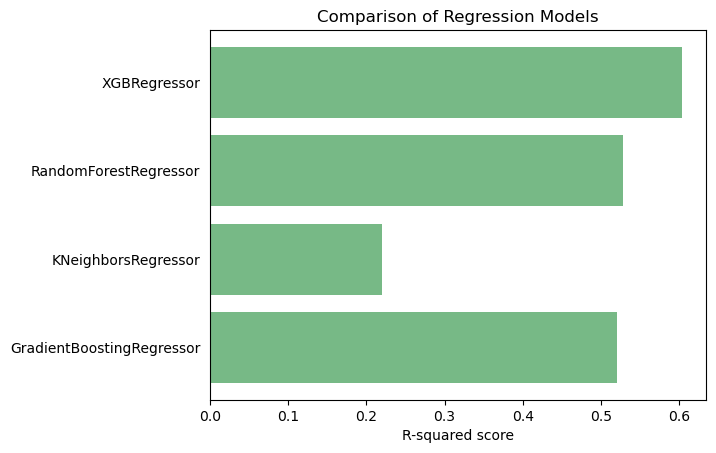

In [20]:
# R2 score results
fig, ax = plt.subplots()
ind = range(len(r2))
ax.barh(ind, list(r2.values()), align='center', 
        color = '#55a868', alpha=0.8)
ax.set_yticks(ind)
ax.set_yticklabels(r2.keys())
ax.set_xlabel('R-squared score')
ax.tick_params(left=False, top=False, right=False) 
ax.set_title('Comparison of Regression Models')
#fig.savefig('images/compare_models.png', bbox_inches = 'tight')

In [21]:
#R2 Values
for key, value in r2.items():
    print(f"Key: {key}, Value: {value}")

Key: GradientBoostingRegressor, Value: 0.520799935008655
Key: KNeighborsRegressor, Value: 0.2196412208098515
Key: RandomForestRegressor, Value: 0.5284204642419412
Key: XGBRegressor, Value: 0.604343214448636


Text(0.5, 1.0, 'Comparison of Regression Models')

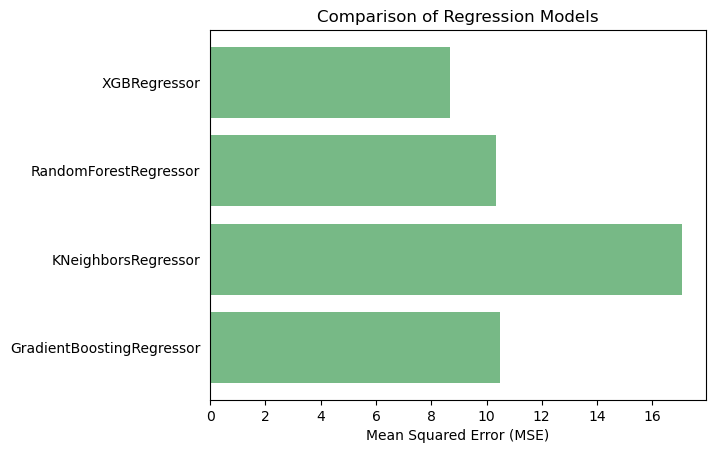

In [22]:
# mse score results
fig, ax = plt.subplots()
ind = range(len(mse))
ax.barh(ind, list(mse.values()), align='center', 
        color = '#55a868', alpha=0.8)
ax.set_yticks(ind)
ax.set_yticklabels(mse.keys())
ax.set_xlabel('Mean Squared Error (MSE)')
ax.tick_params(left=False, top=False, right=False) 
ax.set_title('Comparison of Regression Models')

In [23]:
#MSE Values
for key, value in mse.items():
    print(f"Key: {key}, Value: {value}")

Key: GradientBoostingRegressor, Value: 10.493854867362673
Key: KNeighborsRegressor, Value: 17.08883694212695
Key: RandomForestRegressor, Value: 10.326975241025298
Key: XGBRegressor, Value: 8.664366280789716


Text(0.5, 1.0, 'Comparison of Regression Models')

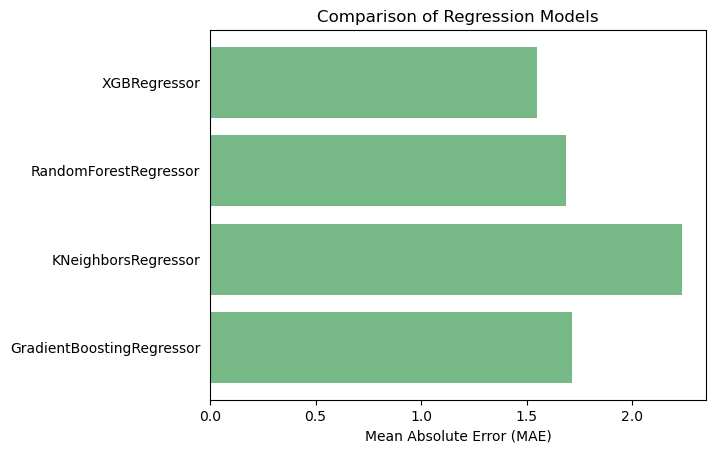

In [24]:
# mae score results
fig, ax = plt.subplots()
ind = range(len(mae))
ax.barh(ind, list(mae.values()), align='center', 
        color = '#55a868', alpha=0.8)
ax.set_yticks(ind)
ax.set_yticklabels(mae.keys())
ax.set_xlabel('Mean Absolute Error (MAE)')
ax.tick_params(left=False, top=False, right=False) 
ax.set_title('Comparison of Regression Models')

In [25]:
#MAE Values
for key, value in mae.items():
    print(f"Key: {key}, Value: {value}")

Key: GradientBoostingRegressor, Value: 1.7147232102121142
Key: KNeighborsRegressor, Value: 2.238807677870846
Key: RandomForestRegressor, Value: 1.6877608309744911
Key: XGBRegressor, Value: 1.5476066202460712


Text(0.5, 1.0, 'Comparison of Regression Models')

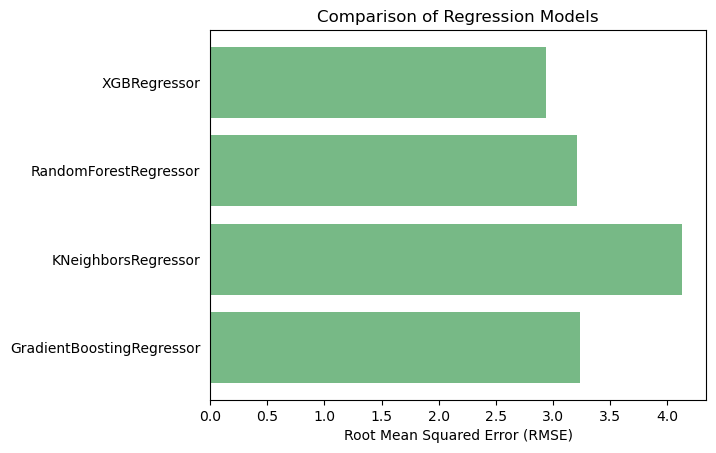

In [26]:
# rmse score results
fig, ax = plt.subplots()
ind = range(len(rmse))
ax.barh(ind, list(rmse.values()), align='center', 
        color = '#55a868', alpha=0.8)
ax.set_yticks(ind)
ax.set_yticklabels(rmse.keys())
ax.set_xlabel('Root Mean Squared Error (RMSE)')
ax.tick_params(left=False, top=False, right=False) 
ax.set_title('Comparison of Regression Models')

In [27]:
#RMSE value
for key, value in rmse.items():
    print(f"Key: {key}, Value: {value}")

Key: GradientBoostingRegressor, Value: 3.2394219958756025
Key: KNeighborsRegressor, Value: 4.133864649710601
Key: RandomForestRegressor, Value: 3.2135611463025406
Key: XGBRegressor, Value: 2.9435295617319213


In [15]:
# XGBRegressor will be used as the LOS prediction model
reg_model = XGBRegressor(random_state=0)   
reg_model.fit(X_train, y_train)
y_test_preds = reg_model.predict(X_test)
r2_not_refined = r2_score(y_test, y_test_preds)
mse_not_refined = mean_squared_error(y_test, y_test_preds)
mae_not_refined = mean_absolute_error(y_test, y_test_preds)
rmse_not_refined = mean_squared_error(y_test, y_test_preds, squared=False)
print(f"R2 score is: {r2_not_refined}") 
print(f"MSE score is: {mse_not_refined}") 
print(f"MAE score is: {mae_not_refined}") 
print(f"RMSE score is: {rmse_not_refined}") 

R2 score is: 0.604343214448636
MSE score is: 8.664366280789716
MAE score is: 1.5476066202460712
RMSE score is: 2.9435295617319213


 # Model Refinement

In [10]:
# Split into train 80% and test 20%
X_train, X_test, y_train, y_test = train_test_split(features, 
                                                    LOS, 
                                                    test_size = .20, 
                                                    random_state = 42)

xgb_model = XGBRegressor(objective='reg:squarederror', random_state=42)

# Define the parameter grid for grid search
param_grid = {
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'n_estimators': [100, 200, 300],
    'alpha': [0, 0.1, 1],
    'lambda': [0, 0.1, 1]
}

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=5, n_jobs=-1)

# Perform grid search on the training data
grid_search.fit(X_train, y_train, early_stopping_rounds=10, eval_set=[(X_test, y_test)], verbose=0)

# Get the best estimator from grid search
best_xgb_model = grid_search.best_estimator_

# Evaluate the best model on the test set
y_pred = best_xgb_model.predict(X_test)

# Calculate evaluation metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)

# Print the best parameters found
print("Best Parameters:", grid_search.best_params_)

C:\Users\User\anaconda3\envs\fyp\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


Best Parameters: {'alpha': 0, 'lambda': 1, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 300}


In [13]:
#fit the model using the best params
refined_xgb_model = XGBRegressor(reg_alpha=0, reg_lambda=1, learning_rate=0.1, 
                                 max_depth=7, n_estimators=300)
# Fit the model to the training data
refined_xgb_model.fit(X_train, y_train)

y_test_preds = refined_xgb_model.predict(X_test)
r2_optimized = r2_score(y_test, y_test_preds)
mse_optimized = mean_squared_error(y_test, y_test_preds)
mae_optimized = mean_absolute_error(y_test, y_test_preds)
rmse_optimized = mean_squared_error(y_test, y_test_preds, squared=False)
print("Optimized R2 score is: {:2f}".format(r2_optimized)) 
print("Optimized MSE score is: {:2f}".format(mse_optimized)) 
print("Optimized MAE score is: {:2f}".format(mae_optimized)) 
print("Optimized RMSE score is: {:2f}".format(rmse_optimized)) 

Optimized R2 score is: 0.639121
Optimized MSE score is: 7.902774
Optimized MAE score is: 1.420043
Optimized RMSE score is: 2.811187


In [28]:
print('Model refinement improved R2 score by {:.4f}'.format(r2_optimized-r2_not_refined))

Model refinement improved R2 score by 0.0348


# Result

In [29]:
LOS_predict = y_test_preds[:20]
LOS_actual = y_test[:20]

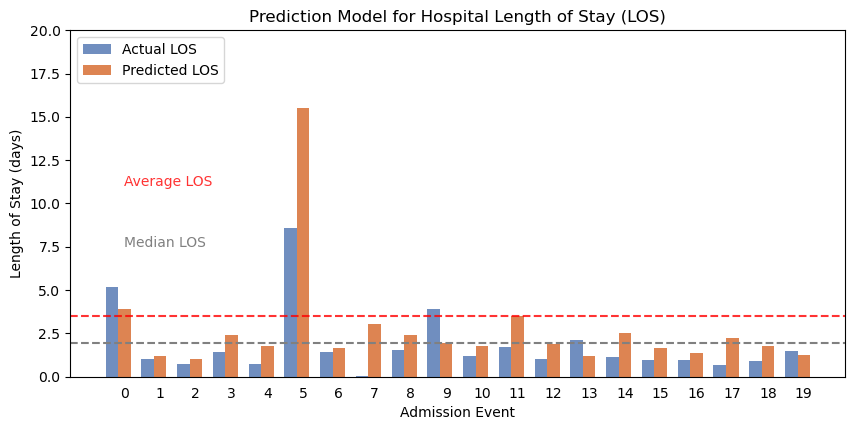

In [30]:
fig, ax = plt.subplots(figsize=(10, 4.5))

ind = np.arange(0,20)
pad = 0.15
width = 0.35
set_actual = ax.bar(pad+ind, LOS_actual, width, color='#4c72b0', alpha=0.8)
set_predict = ax.bar(pad+ind+width, LOS_predict, width, color='#dd8452')

ax.set_ylabel('Length of Stay (days)')
ax.set_xlabel('Admission Event')
ax.set_title('Prediction Model for Hospital Length of Stay (LOS)')
ax.text(0.5, 11, 'Average LOS', fontdict=None, color='red', alpha=0.8)
ax.text(0.5, 7.5, 'Median LOS', fontdict=None, color='gray')
ax.set_xticks(pad + ind + width)
ax.set_ylim(0, 20)
ax.set_xticklabels(list(range(20)))
ax.axhline(y=actual_median_los, xmin=0, xmax=20, ls='--', color='gray')
ax.axhline(y=actual_mean_los, xmin=0, xmax=20, ls='--', color='red', alpha=0.8)
ax.legend( (set_actual, set_predict), ('Actual LOS', 'Predicted LOS'), 
          loc='upper left')
ax.tick_params(bottom=False, top=False, right=False)

In [31]:
#save the model
import pickle

filename = './data/model/los_model.sav'
with open(filename, 'wb') as file:
    pickle.dump(refined_xgb_model, file)